In [202]:
import gizmo_analysis as gizmo  # rename these packages for brevity
import utilities as ut  # rename these packages for brevity

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy import constants as cst

# from aqn import *
# from constants import *
import pickle
import scipy.stats as stats


In [2]:
# read in FIRE m12i
# simulation_directory = 'FIRE/m12i_res7100'
# part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)

with open('../data/FIRE/part.pkl', 'rb') as file: part = pickle.load(file)
print(">> imported FIRE simulation data")

>> imported FIRE simulation data


In [3]:
# define cube resolution parameters
cube_length       = 20   # kpc
voxel_resolution  = 2**9 # bins / kpc
print(f">> voxels per length: {voxel_resolution}")

voxel_length = cube_length / voxel_resolution * u.kpc
voxel_volume = voxel_length**3

# create bins based on defined resolution parameters
bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers, bin_centers]) # kpc

# create empty dictionaries for dark matter and gas components
dark_mat, neut_gas, ioni_gas = {}, {}, {}
dark_mat["name"], neut_gas["name"], ioni_gas["name"] = "Dark Matter", "Neutral Gas", "Ionized Gas"
dark_mat["short-name"], neut_gas["short-name"], ioni_gas["short-name"] = "dark_mat", "neut_gas", "ioni_gas"

>> voxels per length: 512


In [4]:
# sort gas into neutral and ionized based on temperature
gas_temp = part['gas'].prop('temperature')
neutral_filter = gas_temp <  3e4
ionized_filter = gas_temp >= 3e4

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
neut_gas["coords"] = part['gas'].prop('host.distance')[neutral_filter]
ioni_gas["coords"] = part['gas'].prop('host.distance')[ionized_filter]

dark_mat["within_cube"] = np.where((np.abs(dark_mat["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(dark_mat["coords"][:,1]) < cube_length/2) &
                                   (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
neut_gas["within_cube"] = np.where((np.abs(neut_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(neut_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(neut_gas["coords"][:,2]) < cube_length/2))
ioni_gas["within_cube"] = np.where((np.abs(ioni_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(ioni_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(ioni_gas["coords"][:,2]) < cube_length/2))

# obtain massses of all particles
dark_mat["masses"] = part['dark'].prop('mass')[dark_mat["within_cube"]]
neut_gas["masses"] = part['gas'].prop('mass')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["masses"] = part['gas'].prop('mass')[ionized_filter][ioni_gas["within_cube"]]

# obtain velocities of all particles
dark_mat["v"] = part['dark'].prop('velocity')[dark_mat["within_cube"]]
neut_gas["v"] = part['gas'].prop('velocity')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["v"] = part['gas'].prop('velocity')[ionized_filter][ioni_gas["within_cube"]]

dark_mat["dist"] = part["dark"].prop('host.distance.total')[dark_mat["within_cube"]]
neut_gas["dist"] = part["gas"].prop('host.distance.total')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["dist"] = part["gas"].prop('host.distance.total')[ionized_filter][ioni_gas["within_cube"]]

print(f">> obtained raw particle masses and velocities")

>> obtained raw particle masses and velocities


In [5]:
# create the plot directly from binning masses
def generate_rho_distrib_parts(comp, distance_bins):
    # pick out particles within the max distance of centre
    within_mw = part[comp].prop('host.distance.total') <= max_distance_kpc.value
    
    # array of distances of each particle to the host Galaxy centre
    dm = part[comp].prop('host.distance.total')[within_mw]
    
    # All DM particles have the same mass:
    mass_comp = (part[comp]['mass'][within_mw][0] * u.Msun).to(u.kg)
    

    # create bins array
    # distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

    res = np.histogram(dm, bins=distance_bins.value)
    N, R = res[0], res[1] * u.kpc
    R_inner, R_outer = R[0:-1], R[1:]

    N_error = np.sqrt(N)

    m       = N * mass_comp
    m_error = m * N_error / N

    V_outer = 4/3 * np.pi * (R_outer).to(u.m)**3
    V_inner = 4/3 * np.pi * (R_inner).to(u.m)**3

    rho       = m / (V_outer-V_inner)
    rho_error = rho * m_error / m
    
    return rho, rho_error

In [6]:
def generate_rho_distrib_cubes(cube, distance_bins, distances, voxel_resolution):
    
    density = cube.reshape((voxel_resolution**3, 1)).T[0]
    # bins = np.unique(np.sort(distances))

    rho, bin_edges, bin_numbers = stats.binned_statistic(distances, 
                      density, 
                      statistic='sum', 
                      bins=distance_bins)

    voxel_length = 20 / voxel_resolution * u.kpc
    voxel_volume = voxel_length**3
    
    rho = rho * u.kg/u.m**3
    R = bin_edges * u.kpc
    R_inner, R_outer = R[0:-1], R[1:]
    
    V_outer = 4/3 * np.pi * (R_outer).to(u.m)**3
    V_inner = 4/3 * np.pi * (R_inner).to(u.m)**3
    
    rho       = rho * voxel_volume.to(u.m**3) / (V_outer-V_inner)

    return rho

In [256]:
def plot_cubes_parts(quant, quant_cube, quant_part, distance_bins, quant_errors):
    plt.figure(dpi=300)
    plt.errorbar(distance_bins[1:], binned_cubes[quant], yerr=quant_errors, marker="o", markersize=3, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7, label="Binned Cube")
    plt.errorbar(distance_bins[1:], binned_parts[quant], yerr=quant_errors, marker="^", markersize=3, linestyle = 'none',color='green', ecolor="gray", elinewidth=0.7, label="Binned Particles")
    # plt.bar(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, width=kpc_per_bin ,color="burlywood", alpha = 0.75)
    # plt.errorbar(R_outer[R_outer.value < 1], rho[R_outer.value < 1], yerr=rho_error[R_outer.value < 1], marker=".", markersize=1, linestyle = 'none',color='red', ecolor="gray", elinewidth=0.7)
    plt.title(quant)
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$\rho$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
    # plt.scatter(A, B, s=3)
    plt.legend(fontsize=20)
    
    plt.savefig("../visuals/"+quant+"-binned-particles-and-cubes.png", bbox_inches='tight')
    plt.savefig("../visuals/"+quant+"-binned-particles-and-cubes.png", bbox_inches='tight')

    plt.show()
    
    plt.figure(dpi=300)
    plt.errorbar(distance_bins[1:], binned_cubes[quant]- binned_parts[quant], yerr=quant_errors, marker="o", markersize=3, linestyle = 'none',color='red', ecolor="gray", elinewidth=0.7)
    plt.title(quant + ": binned cube - binned particle densities")
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$\rho$'+"  [kg$\cdot$m$^{-3}$]", size = 20)

    plt.savefig("../visuals/"+quant+"-binned-particles-vs-cubes.png", bbox_inches='tight')
    plt.savefig("../visuals/"+quant+"-binned-particles-vs-cubes.png", bbox_inches='tight')
    
    plt.show()

def plot_cubes_parts_cum(quant, quant_cube, quant_part, distance_bins, quant_errors):
    plt.figure(dpi=300)
    plt.errorbar(distance_bins[1:], binned_cubes[quant], yerr=quant_errors, marker="o", markersize=3, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7, label="Binned Cube")
    plt.errorbar(distance_bins[1:], binned_parts[quant], yerr=quant_errors, marker="^", markersize=3, linestyle = 'none',color='green', ecolor="gray", elinewidth=0.7, label="Binned Particles")
    # plt.bar(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, width=kpc_per_bin ,color="burlywood", alpha = 0.75)
    # plt.errorbar(R_outer[R_outer.value < 1], rho[R_outer.value < 1], yerr=rho_error[R_outer.value < 1], marker=".", markersize=1, linestyle = 'none',color='red', ecolor="gray", elinewidth=0.7)
    plt.title(quant)
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$m$'+"  [kg]", size = 20)
    # plt.scatter(A, B, s=3)
    plt.legend(fontsize=20)
    
    plt.savefig("../visuals/"+quant+"-binned-particles-and-cubes-cum.png", bbox_inches='tight')
    plt.savefig("../visuals/"+quant+"-binned-particles-and-cubes-cum.png", bbox_inches='tight')

    plt.show()
    
    plt.figure(dpi=300)
    plt.errorbar(distance_bins[1:], binned_cubes[quant]- binned_parts[quant], yerr=quant_errors, marker="o", markersize=3, linestyle = 'none',color='red', ecolor="gray", elinewidth=0.7)
    plt.title(quant + ": binned cube - binned particle masses")
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$m$'+"  [kg]", size = 20)

    plt.savefig("../visuals/"+quant+"-binned-particles-vs-cubes-cum.png", bbox_inches='tight')
    plt.savefig("../visuals/"+quant+"-binned-particles-vs-cubes-cum.png", bbox_inches='tight')
    
    plt.show()

def plot_covariance_matrix(cov_matrix, mass, sampled_densities, name):    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    # Iterate over samples
    col = 0
    
    # Plot for the first column
    ax = axes[0]
    ax.set_title(f"True $\\rho$ - Mean Sampled $\\rho$")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Density")
    
    # ax.bar(distance_bins[1:], , label="Sampled Histogram", alpha=0.8)
    mass_diff = mass.value - np.mean(sampled_densities, axis=0)

    ax.scatter(distance_bins[1:], mass_diff)
    ax.axhline(0, color="r", linestyle="--")
    for i in range(len(distance_bins) - 1):
        ax.plot([distance_bins[i+1].value, distance_bins[i+1].value], [0, mass_diff[i]], color='blue')

    col = 1

    ax = axes[1]
    ax.set_title(f"Correlations")
    
    x, y = np.meshgrid(distance_bins.value, distance_bins.value)
    res = ax.pcolor(x, y, np.corrcoef(np.transpose(sampled_densities)))

    ax.invert_yaxis()
    plt.colorbar(res)
    
    col = 2
    
    # Plot for the second column
    ax = axes[2]
    # ax.set_title(f"inv($\Sigma$)$\cdot\Sigma$")
    ax.set_title(f"inv($\Sigma$)$\cdot\Sigma-1$")
    ax.set_xlabel("Distance")
    ax.set_ylabel("Distance")

    x, y = np.meshgrid(distance_bins.value, distance_bins.value)
    # res = ax.pcolor(x, y, np.linalg.inv(cov_matrix) @ cov_matrix)
    res = ax.pcolor(x, y, np.linalg.inv(cov_matrix) @ cov_matrix - np.diag(np.ones(len(distance_bins)-1)))
    ax.invert_yaxis()
    plt.colorbar(res)


    
    # image = ax.imshow(np.linalg.inv(cov_matrix) @ cov_matrix)
    # plt.colorbar(image)


    # plt.imshow(inv_cov @ cov_matrix - np.diag(np.ones(25))) 

    # col = 3

    # ax = axes[sample, 3]
    # ax.set_title(f"Correlation Coeffs, Covariance Matrix")

    # x, y = np.meshgrid(distance_bins, distance_bins)
    # res = ax.pcolor(x, y, np.corrcoef(cov_matrix))

    # ax.invert_yaxis()
    # plt.colorbar(res)
    
    
    plt.tight_layout()   
    
    # sampled_densities, cov_matrix = my_bootstrap([masses, distances], 
    #                                              generate_rho_distrib_parts_cum, 0.7, 10000)
    
    # plt.figure(dpi=300)
    # # plt.hist(distances * masses)
    # plt.bar(distance_bins[1:], np.mean(sampled_densities, axis=0), label="Sampled Histogram", alpha=0.8)
    # plt.bar(distance_bins[1:], generate_rho_distrib_parts_cum([masses, distances]), label="True Histogram", alpha=0.8)
    plt.savefig("../visuals/cov-degeneracy-result-"+name+".png", bbox_inches='tight')
    plt.savefig("../visuals/cov-degeneracy-result-"+name+".svg", bbox_inches='tight')
    plt.show()

In [8]:
# import cubes and grid_coords
grid_coords = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load("../data/FIRE/grid-ids---dark_mat.npy")

cubes = {}

cubes["dark_mat"] = np.load("../data/FIRE/cubes/cube-dark_mat_density.npy") * u.kg/u.m**3
cubes["ioni_gas"] = np.load("../data/FIRE/cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
cubes["neut_gas"] = np.load("../data/FIRE/cubes/cube-neut_gas_density.npy") * u.kg/u.m**3
cubes["temp"]     = np.load("../data/FIRE/cubes/cube-ioni_gas_temp.npy") * u.K
cubes["dv_ioni"]  = np.load("../data/FIRE/cubes/cube-dv_ioni.npy") * u.m/u.s
cubes["dv_neut"]  = np.load("../data/FIRE/cubes/cube-dv_neut.npy") * u.m/u.s

In [50]:
binned_cubes = {}
binned_parts = {}
errors = {}

quant = "dark_mat"

voxel_resolution = 2**9

# compute distance from every grid centre to galactic centre
distances = np.sqrt(np.sum(grid_coords**2, axis=1)) * u.kpc

# select maximum distance -- can be set manually to 10 kpc
max_distance_kpc = 10 * u.kpc#np.max(distances)

# create distance bins
num_bins = 25
distance_bins = np.linspace(0, max_distance_kpc.value, num_bins+1, endpoint=True) * u.kpc
# distance_bins = np.logspace(-2, max_distance_kpc.value, num_bins+1, endpoint=True) * u.kpc


In [19]:
# binned_cubes[quant]                = generate_rho_distrib_cubes(cubes[quant], distance_bins, distances, voxel_resolution)
# binned_parts[quant], errors[quant] = generate_rho_distrib_parts("dark", distance_bins)

# # plot_cubes_parts(quant, binned_cubes[quant], binned_parts[quant], distance_bins, errors[quant])

In [12]:
def generate_rho_distrib_cubes_cum(cube, distance_bins, distances, voxel_resolution):
    
    density = cube.reshape((voxel_resolution**3, 1)).T[0]
    
    density_cum = np.array([np.sum(density[distances < distance_bins[i]]).value * voxel_volume.to(u.m**3).value for i in range(1,len(distance_bins))]) * u.kg
    # / (4/3 * np.pi * distance_bins[i]**3).value
    return density_cum

In [259]:
# create the plot directly from binning masses
def generate_rho_distrib_parts_cum(comp, distance_bins):
    # pick out particles within the max distance of centre
    within_mw = part[comp].prop('host.distance.total') <= max_distance_kpc.value
    
    # array of distances of each particle to the host Galaxy centre
    dm = part[comp].prop('host.distance.total')[within_mw] * u.kpc

    mass_comp = (part[comp]['mass'][within_mw] * u.Msun)
    
    mass_cum = np.array([(np.sum(mass_comp[dm < distance_bins[i]])).to(u.kg).value for i in range(1,
              len(distance_bins))]) * u.kg

    N = np.array([np.sum(dm < distance_bins[i]) for i in range(1, len(distance_bins))])
    
    mass_cum_error = mass_cum / np.sqrt(N)
    
    return mass_cum, mass_cum_error

In [260]:
binned_cubes[quant] = generate_rho_distrib_cubes_cum(cubes[quant], distance_bins, distances, voxel_resolution)
binned_parts[quant], errors[quant] = generate_rho_distrib_parts_cum("dark", distance_bins)

# binned_cubes[quant]                = generate_rho_distrib_cubes(cubes[quant], distance_bins, distances, voxel_resolution)
# binned_parts[quant], errors[quant] = generate_rho_distrib_parts("dark", distance_bins)

# plot_cubes_parts_cum(quant, binned_cubes[quant], binned_parts[quant], distance_bins, errors[quant])
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

In [15]:
from scipy.stats import bootstrap

In [104]:
# create the plot directly from binning masses
def generate_rho_distrib_parts_cum(data):
    masses, distances = data[0], data[1]
    # print(masses)
    masses_cum = np.array([(np.sum(masses[distances < distance_bins[i]])).to(u.kg).value for i in range(1,
                  len(distance_bins))]) * u.kg
    
    return masses_cum #/ (4/3 * np.pi * distance_bins[1:]**3).to(u.m**3)

def my_bootstrap(data, bsfunction, fraction, num_samples):
    length = len(data[0])
    samples_indexes = np.random.choice(length, size=(num_samples, round(fraction * length)))
    
    res = np.array([bsfunction([data[0][samples_indexes[i,:]], data[1][samples_indexes[i,:]]]) for i in range(num_samples)])
    
    return res*1/fraction, (1/fraction)**2 * np.cov(res.T)
#                ^^^ Need to find source

In [51]:
import time
t0 = time.time()
sampled_densities, cov_matrix = my_bootstrap([dark_mat["masses"]* u.Msun, dark_mat["dist"] * u.kpc], 
                                             generate_rho_distrib_parts_cum, 0.7, 100)
print(time.time()-t0)

22.48930287361145


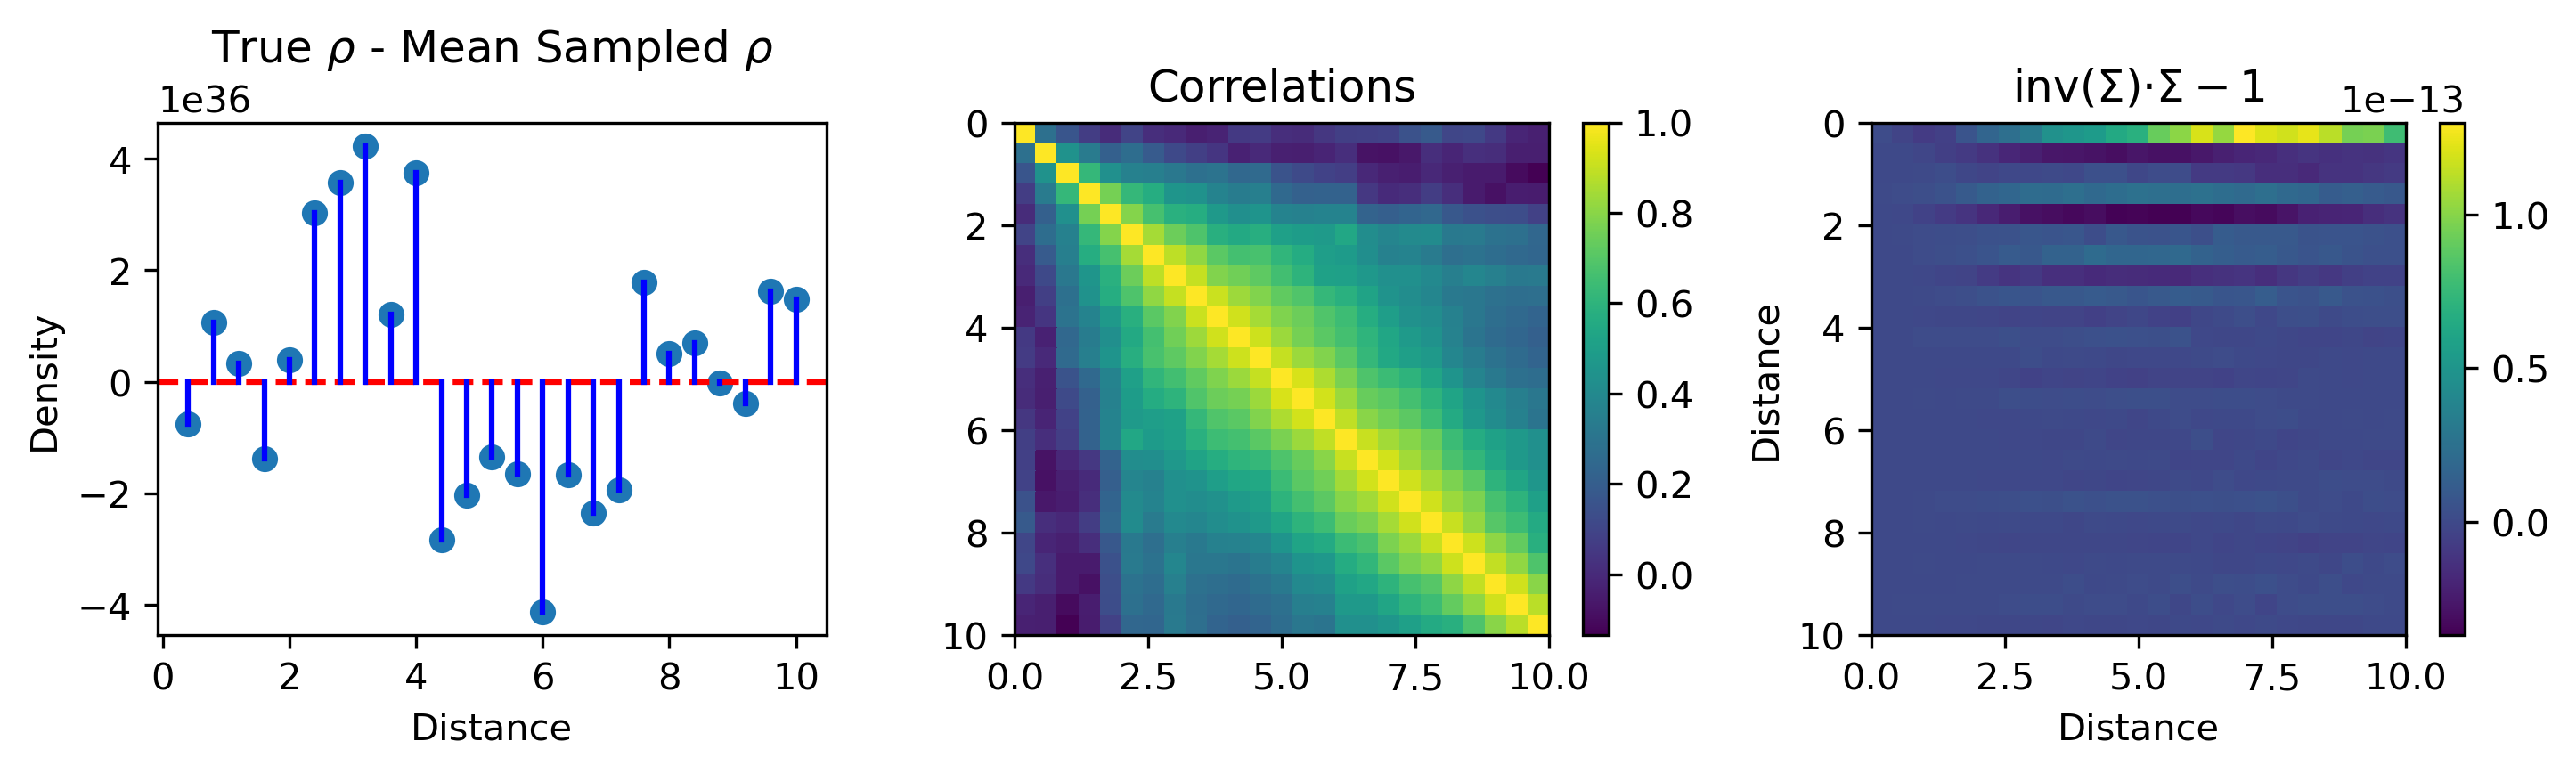

In [261]:
plot_covariance_matrix(cov_matrix, binned_parts[quant], sampled_densities, "dark-mat") 

In [87]:
# sampled_densities
# cum_density = cumtrapz(rho_values, R, initial=0)
import scipy.integrate as integrate
def rho_gNFW_cum(R, parameters):
    return integrate.cumtrapz(2 * np.pi * ((R*u.kpc).to(u.m))**2 * rho_gNFW(R, parameters), initial=0)

# def rho_burkert_cum2(R, parameters):
#     # initial guesses: [vh, r0] = [4.14, 7.8] # [km/(100s), kpc]
    
#     vh, r0 = parameters
    
#     R_kpc   = R  * u.kpc

#     vh_km_s = vh * 100 * u.km / u.s
#     r0_kpc  = r0 * u.kpc
    
#     rho0_kg_m3 = (vh_km_s**2 / (4*np.pi * r0_kpc**2 * cst.G)).to(u.kg/u.m**3)
    
#     return (rho0_kg_m3 * r0_kpc**3 / ( (R_kpc+r0_kpc)*((R_kpc)**2 + r0_kpc**2) )).value # kg/m^3

In [89]:
import emcee
from multiprocessing import Pool,cpu_count
import corner

# 2. likelihood
def compute_inv_cov_mat(errors, num_bins):
    cov_mat = np.zeros([num_bins, num_bins])
    for i in range(num_bins):
        cov_mat[i,i] = errors[i].value**2
    inv_cov = np.linalg.inv(cov_mat)

    return inv_cov

def lnlike(parameters, x, observation, theory_function):
    # vh, r0 = parameters
    theory = theory_function(x, parameters)

    difference = theory - observation

    lnlike = -0.5*float(difference @ inv_cov @ difference)
    return lnlike

# 3. numerator of Bayes' formula
def lnprob(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior(parameters)
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)


def run_mcmc(distance_bins, quantity, quant, model_name, model_function, lnprior_function, lnprob_function, parameter_names, initial_guess, nwalkers, nsteps, burnout):  
    
    ndim = len(initial_guess)
    starting_pts = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)] # initial points for each walkers
    with Pool() as pool: # parallelization, remove this if you only want 1 cpu
        sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob_function,pool=pool, args=(distance_bins[1:].value, quantity.value, model_function)) 
        sampler.run_mcmc(starting_pts,nsteps,progress=True) 
        # run your mcmc, you can monitor that via a progress bar if you have some package (that I forgot) installed
        # otherwise you need to set progress=False

    analysis_chain = sampler.flatchain[nwalkers*burnout:]
    # np.save('../data/FIRE/MCMC-chains/'+quant+"-"+model_name+".npy", sampler.flatchain) # here saves your sampled posterior chain files
    
    # means
    posterior_means = np.average(np.array(analysis_chain),axis=0) # use posterior mean instead of max posterior, which is what mcmc bad at to find
    posterior_std = np.std(np.array(analysis_chain),axis=0)
    toprint = 'The constraints are:\n'
    for i in range(ndim):
        # toprint = toprint+parameter_names[i]+'='+str(posterior_means[i])[:5]+'+-'+str(posterior_std[i])[:4]+"\n"
        toprint = toprint+parameter_names[i]+' = '+str(posterior_means[i])+' +- '+str(posterior_std[i])+"\n"
    print(toprint)
    

    # plots
    fig,ax = plt.subplots(len(initial_guess),1, dpi=300) # figsize=(len(initial_guess)*1.5, 6)
    res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3, linewidth=0.5) for i in range(len(initial_guess))]
    res = [ax[i].plot(np.arange(0,len(sampler.flatchain)/nwalkers,1/nwalkers), sampler.flatchain[0:][:,i], 
                      '-', color='red', alpha=0.1, linewidth=0.5) for i in range(len(initial_guess))]
    res = ax[len(initial_guess)-1].set_xlabel("step",size=12)
    res = [ax[i].set_ylabel(parameter_names[i], size=12) for i in range(len(initial_guess))]
    res = [ax[i].set_xticks([]) for i in range(len(initial_guess)-1)]
    res = [ax[i].axvline(nwalkers*burnout/nwalkers, color="red") for i in range(len(initial_guess))]
    res = [ax[i].axhline(initial_guess[i]) for i in range(len(initial_guess))]
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-walkers.png", bbox_inches='tight')
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-walkers.svg", bbox_inches='tight')
    plt.show()
    # plt.figure(dpi=150)
    # plt.errorbar(R_outer, rho_c, yerr=rho_c_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
    # plt.plot(R_outer, rho_c_burkert_2(R_outer.value, posterior_means))
    # # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
    # plt.title("Cumulative Density Distribution")
    # plt.xlabel("R [kpc]", size=20)
    # plt.ylabel(r'$\rho^c_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
    # plt.yscale('log')
    # plt.show()

    plt.figure(dpi=300)
    plt.errorbar(distance_bins[1:], quantity, yerr=np.std(sampled_densities, axis=0)*u.kg/u.m**3, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
    plt.plot(distance_bins[1:], model_function(distance_bins[1:].value, posterior_means))
    # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
    plt.title("Density Distribution, "+model_name)
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
    plt.yscale('log')
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-fit.png", bbox_inches='tight')
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-fit.svg", bbox_inches='tight')
    plt.show()
    
    corner_fig = plt.figure(dpi=400)
    corner.corner(
        analysis_chain, labels=parameter_names, truths=posterior_means, fig=corner_fig
    )
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-corner.png", bbox_inches='tight')
    plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-corner.svg", bbox_inches='tight')
    plt.show()
    
    return analysis_chain, posterior_means


In [279]:
from scipy.integrate import cumtrapz
########### Burkert Profile #######################################
vh = 414# * u.km / u.s
r0 = 7.8# * u.kpc
# rho0 = (vh**2 / (4*np.pi * r0**2 * cst.G)).to(u.kg/u.m**3)

# 0. distribution model
def rho_burkert(R, parameters):
    # initial guesses: [vh, r0] = [4.14, 7.8] # [km/(100s), kpc]
    
    vh, r0 = parameters
    
    R_kpc   = R  * u.kpc

    vh_km_s = vh * 100 * u.km / u.s
    r0_kpc  = r0 * u.kpc
    
    rho0_kg_m3 = (vh_km_s**2 / (4*np.pi * r0_kpc**2 * cst.G)).to(u.kg/u.m**3)
    
    return (rho0_kg_m3 * r0_kpc**3 / ( (R_kpc+r0_kpc)*((R_kpc)**2 + r0_kpc**2) )).value # kg/m^3

def rho_burkert_cum(R, parameters):
    return cumtrapz(2 * np.pi * ((R*u.kpc).to(u.m))**2 * rho_burkert(R, parameters), R, initial=0)

# 1. prior
def lnprior_burkert(parameters):
    vh, r0 = parameters
    if vh <= 0 or r0 <= 0 or vh*1/(3*10**5)>=1:
        return -np.inf
    return 0

def lnprob_burkert(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior_burkert(parameters)
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)
#####################################################################

########### Generalized Einasto Profile #############################
def rho_gEinasto(R, parameters):
    rho_s, r_s, alpha, gamma = parameters
    
    R_kpc   = R  * u.kpc
    rho_s_msol_kpc3 = rho_s * u.solMass / u.kpc**3 * 1e7
    r_s_kpc = r_s * u.kpc
    
    rho_s_kg_m3 = (rho_s_msol_kpc3).to(u.kg/u.m**3)

    return (rho_s_kg_m3 * (R_kpc/r_s_kpc)**(-gamma) * np.exp((-2/alpha)*((R_kpc/r_s_kpc)**alpha - 1))).value  

def lnprior_gEinasto(parameters):
    rho_s, r_s, alpha, gamma = parameters
    if rho_s < 0 or r_s < 0 or r_s > 200 or alpha < 0 or alpha > 5 or gamma < -5 or gamma > 5:
        return -np.inf
    return 0

def lnprob_gEinasto(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior_gEinasto(parameters)
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)
#####################################################################

########### Einasto Profile #########################################
def rho_Einasto(R, parameters):
    rho_s, r_s, alpha = parameters
    return rho_gEinasto(R, [rho_s, r_s, alpha, 0])

def lnprior_Einasto(parameters):
    rho_s, r_s, alpha = parameters
    if rho_s < 0 or r_s < 0 or r_s > 200 or alpha < 0 or alpha > 5:
        return -np.inf
    return 0

def lnprob_Einasto(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior_Einasto(parameters)
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)
#####################################################################

########### Generalized NFW Profile #################################
def rho_gNFW(R, parameters):
    rho_s, r_s, alpha, beta, gamma = parameters
        
    R_kpc   = R  * u.kpc
    rho_s_msol_kpc3 = rho_s * u.solMass / u.kpc**3 * 1e7
    r_s_kpc = r_s * u.kpc
    
    rho_s_kg_m3 = (rho_s_msol_kpc3).to(u.kg/u.m**3)
    
    return (( (2**((beta - gamma)/alpha)) * rho_s_kg_m3 ) / ( (R_kpc/r_s_kpc)**gamma * (1+(R_kpc/r_s_kpc)**alpha)**((beta - gamma)/alpha)  )).value

def lnprior_gNFW(parameters):
    rho_s, r_s, alpha, beta, gamma = parameters
    if rho_s <= 0 or r_s <= 0 or r_s >= 200 or alpha <= 0 or alpha >= 5 or beta <= 0 or beta >= 10 or gamma <= 0 or gamma >= 5:
        return -np.inf
    return 0

def lnprob_gNFW(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior_gNFW(parameters)
    
    # print(lgprior, "_")
    
    if (not np.isfinite(lgprior)) or (np.isnan(lgprior)): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)
#####################################################################


########### NFW Profile #############################################
# def rho_NFW(R, parameters):
#     rho_s, r_s = parameters

#     return rho_gNFW(R, [rho_s, r_s, 2, 0, 0])

def rho_NFW(R, parameters):
    # initial guesses: [rho_0h, r_h] = [1.0,1.9] # [100solMass/pc^3, kpc/10]
    
    rho_0h, r_h = parameters    
    
    R_kpc   = R  * u.kpc
    
    rho_0h_mol_pc  = rho_0h * u.solMass / u.pc**3 / 100
    r_h_kpc     = r_h * u.kpc * 10

    return (rho_0h_mol_pc.to(u.kg/u.m**3) / ((R_kpc/r_h_kpc)*(1+R_kpc/r_h_kpc)**2))

def rho_NFW_cum(R, parameters):
    # initial guesses: [rho_0h, r_h] = [1.0,1.9] # [100solMass/pc^3, kpc/10
    def integrate_func(R, parameters):
        return 2 * np.pi * ((R*u.kpc).to(u.m))**2 * (R*u.kpc).to(u.m) * rho_NFW(R, parameters)
    return cumtrapz(integrate_func(R,parameters), R, initial=0).value

def lnprior_NFW(parameters):
    rho_0h, r_h = parameters
    if rho_0h <= 0 or r_h <= 0 or r_h >= 200:
        return -np.inf
    return 0

def lnprob_NFW(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior_NFW(parameters)
    
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)
#####################################################################

# initial_guess = [1e7,120,1,0.25]


# https://emcee.readthedocs.io/en/stable/tutorials/line/

In [237]:
mcmc_dict = {}

In [262]:
# binned_cubes[quant] = generate_rho_distrib_cubes_cum(cubes[quant], distance_bins, distances, voxel_resolution)
# binned_parts[quant], errors[quant] = generate_rho_distrib_parts_cum("dark", distance_bins)

# binned_cubes[quant]                = generate_rho_distrib_cubes(cubes[quant], distance_bins, distances, voxel_resolution)
binned_parts[quant], errors[quant] = generate_rho_distrib_parts("dark", distance_bins)

In [229]:
mcmc_dict = {}

100%|██████████| 4000/4000 [01:28<00:00, 45.43it/s]


The constraints are:
$v_h$ [km$\cdot$(100s)$^{-1}$] = 2.7163378433044807 +- 0.26388939747803136
$r_0$ [kpc] = 0.9832469477398021 +- 0.6898533669615332



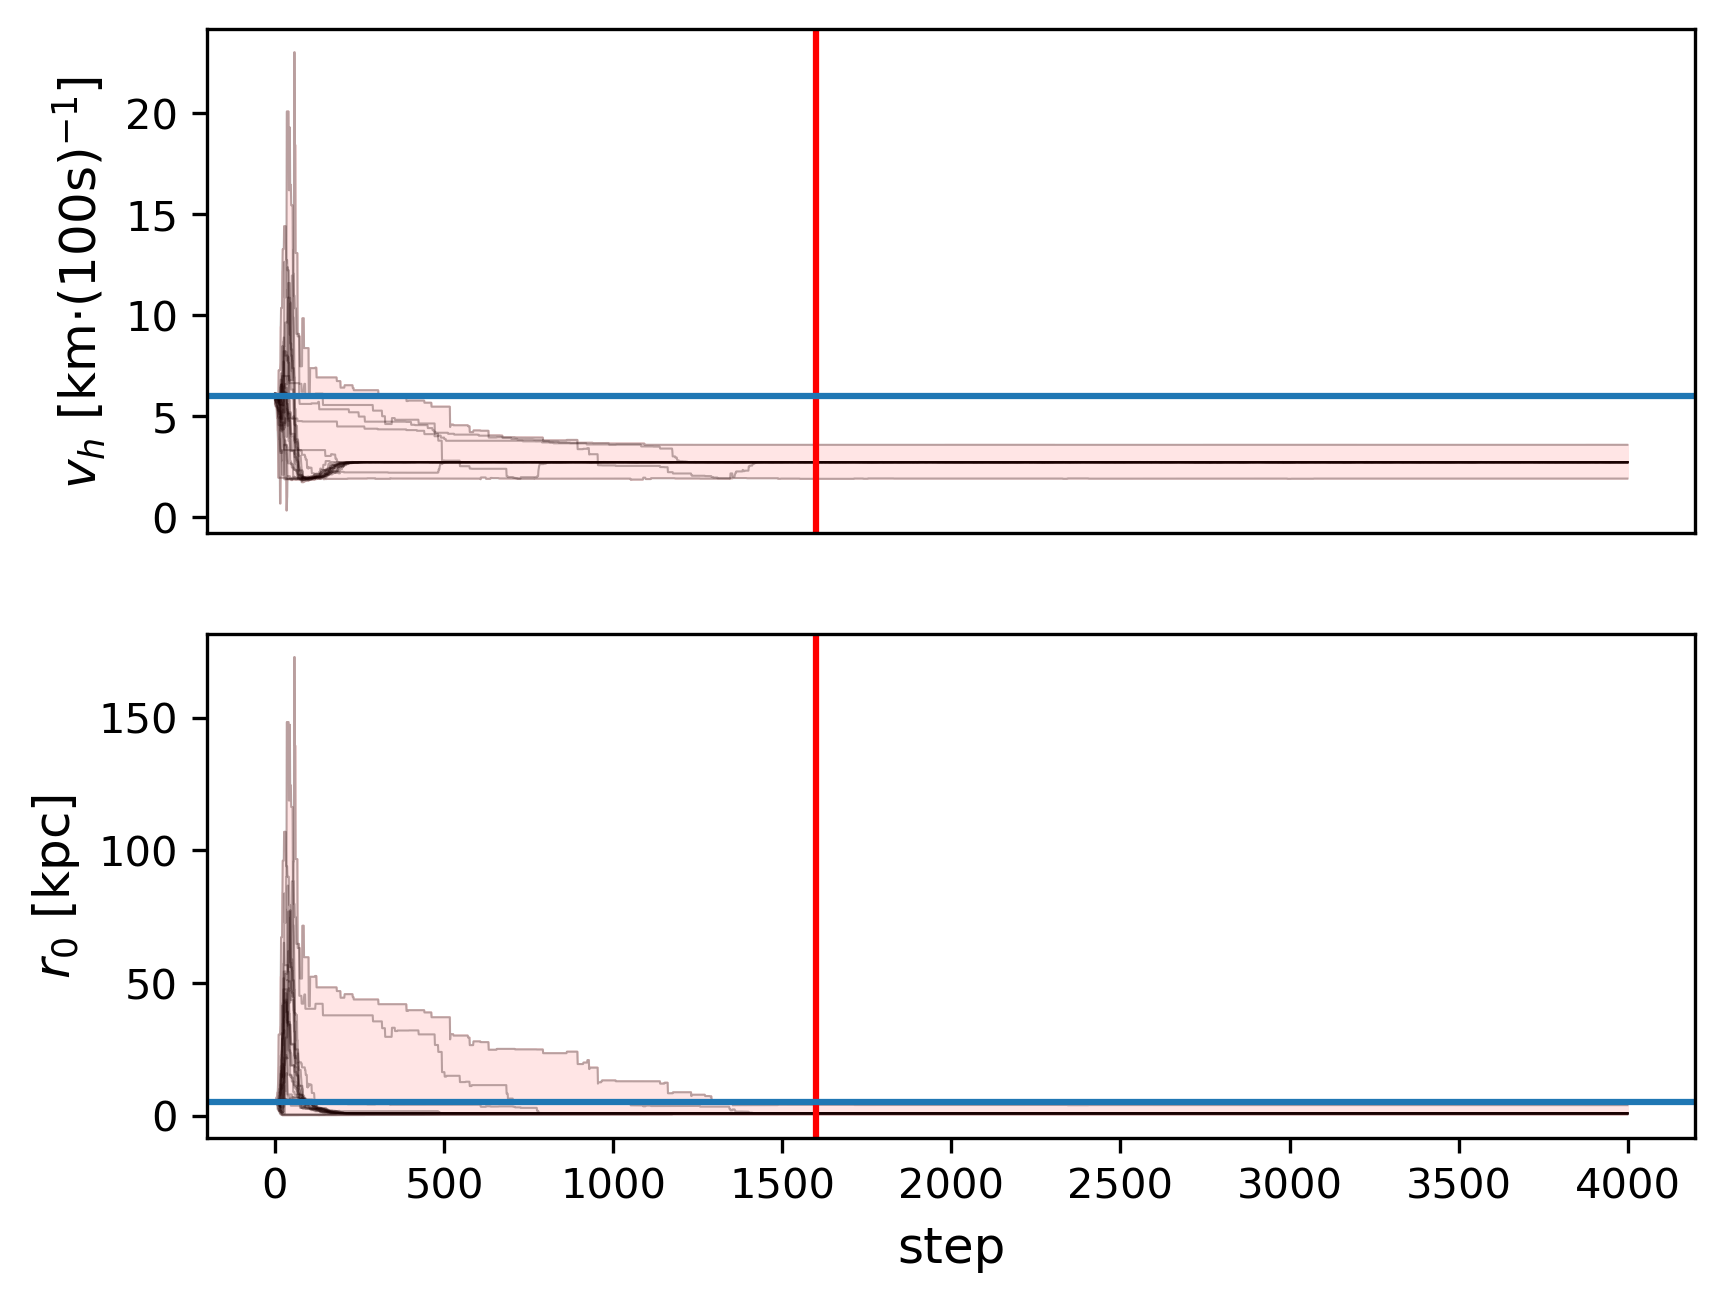

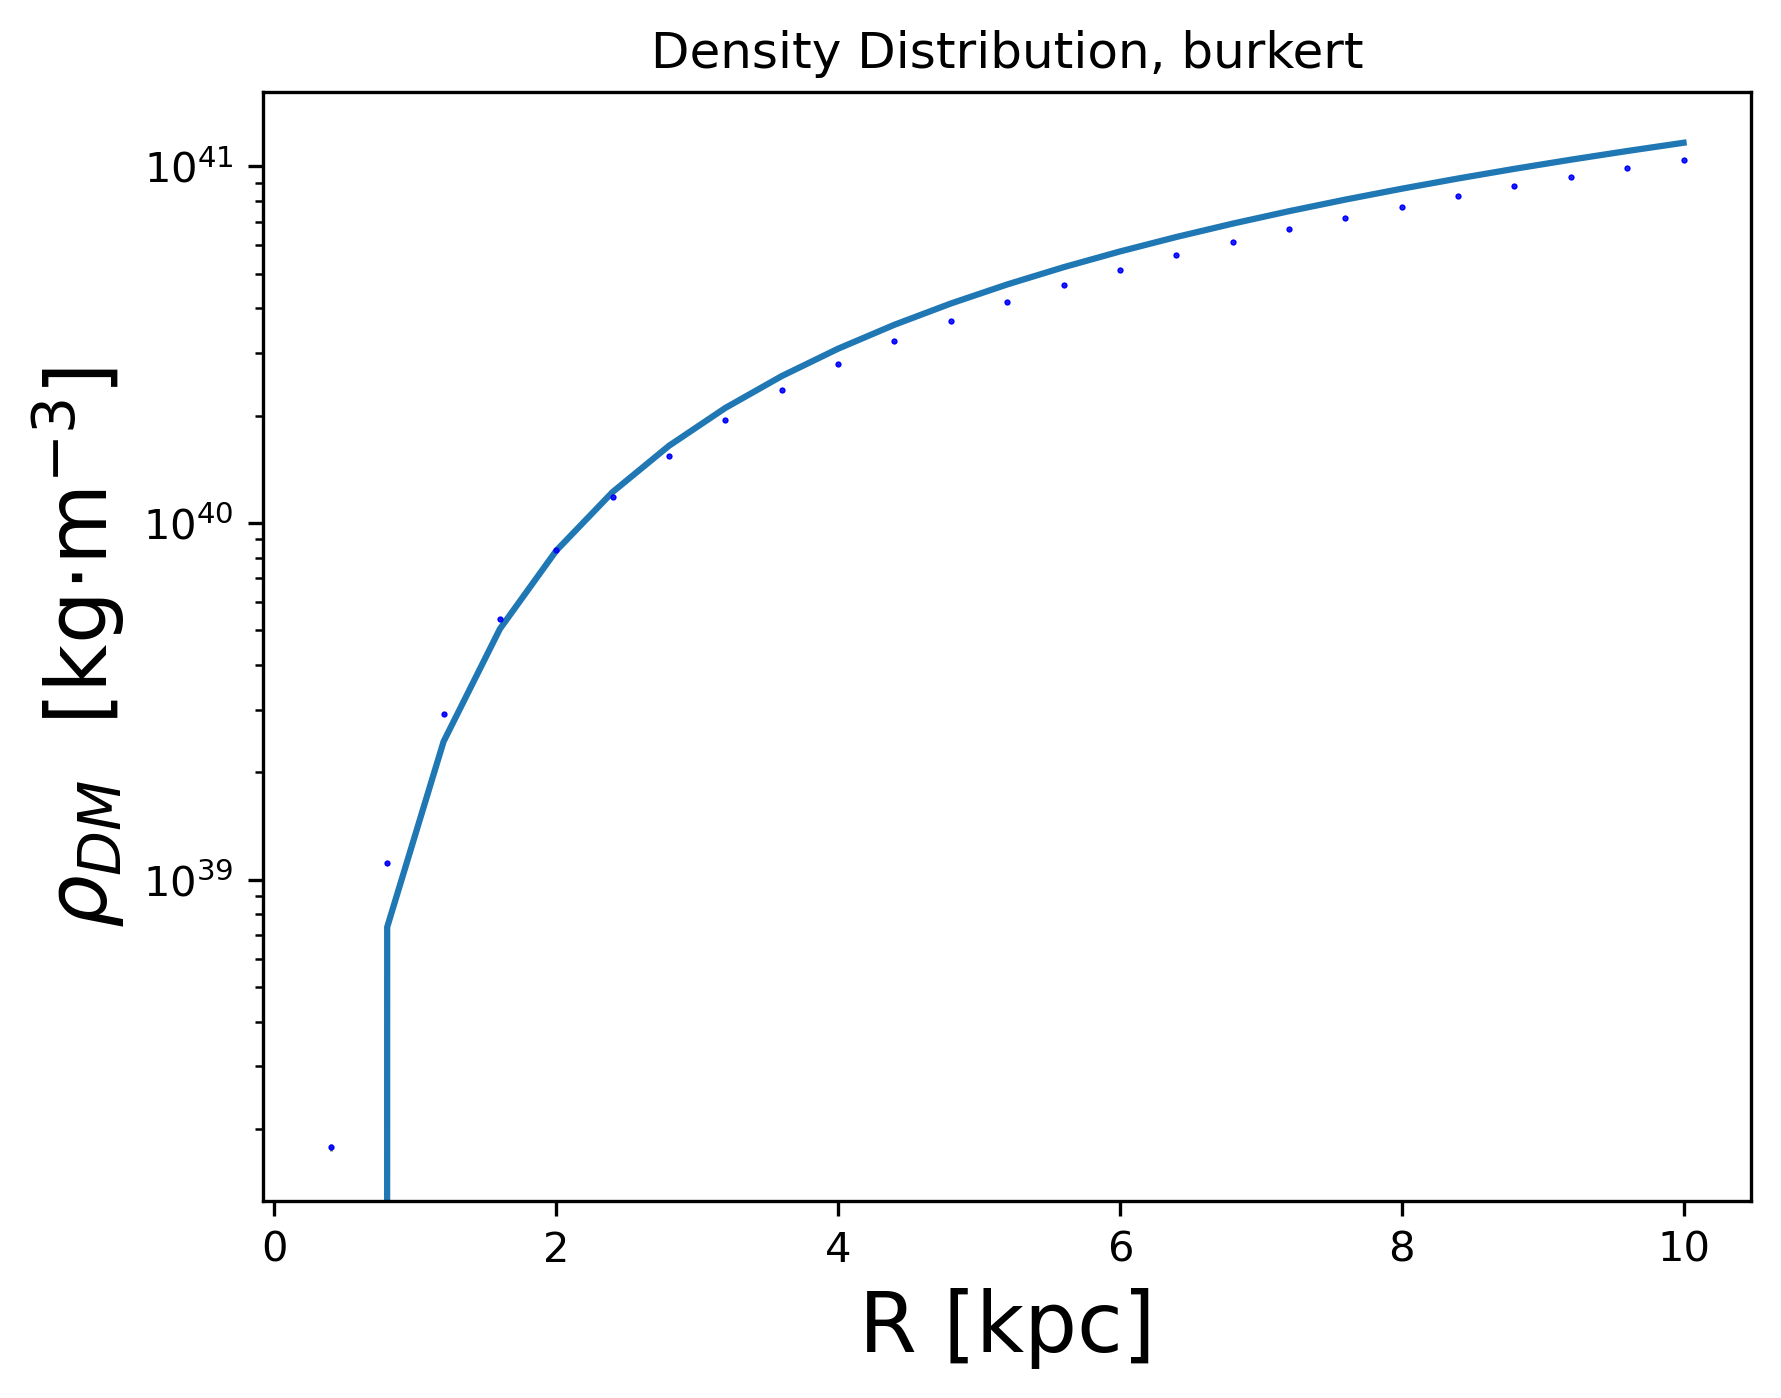

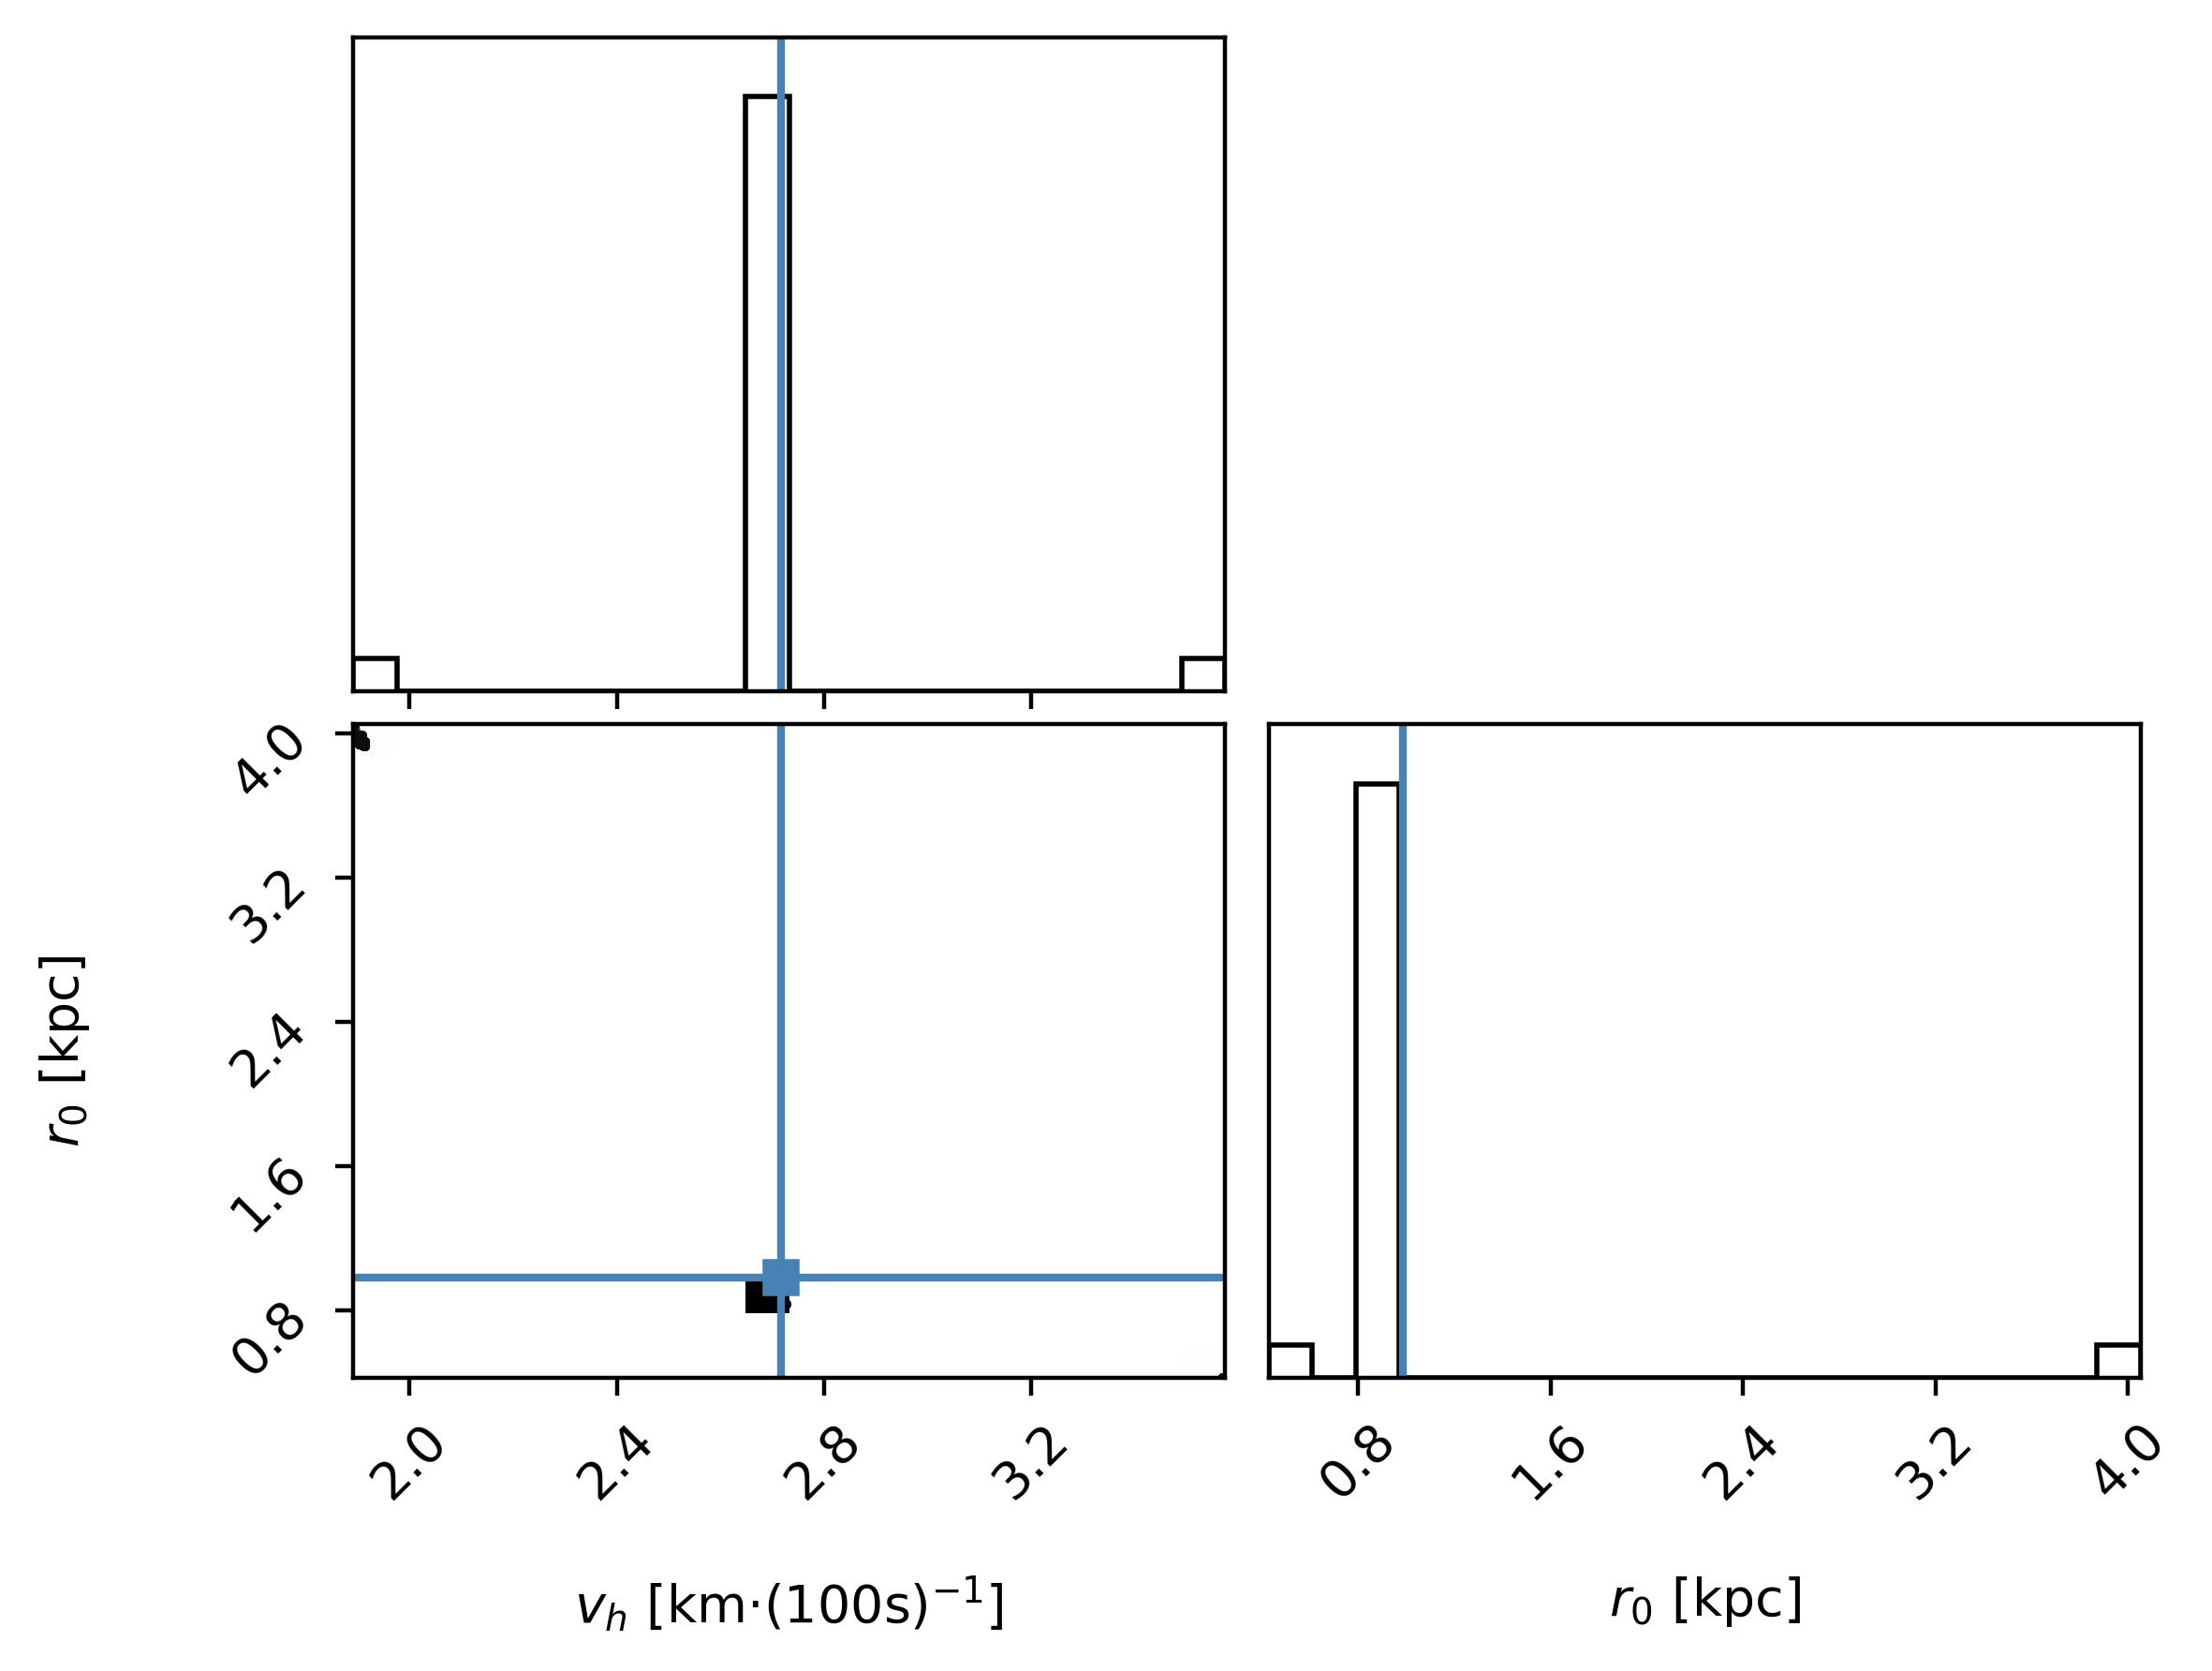

NameError: name 'mcmc_dict' is not defined

In [217]:
vh, r0 = 4.14, 4
# inv_cov = compute_inv_cov_mat(errors[quant], num_bins)
inv_cov = np.linalg.inv(cov_matrix)
mcmc_dict["burkert"] = run_mcmc(distance_bins, np.mean(sampled_densities, axis=0)*u.kg/u.m**3, quant,
                                "burkert", rho_burkert_cum, lnprior_burkert, lnprob_burkert, 
                                ["$v_h$ [km$\cdot$(100s)$^{-1}$]", "$r_0$ [kpc]"], 
                                initial_guess = [6,5], 
                                nwalkers=20, nsteps=4000, burnout=int(0.4*4000))

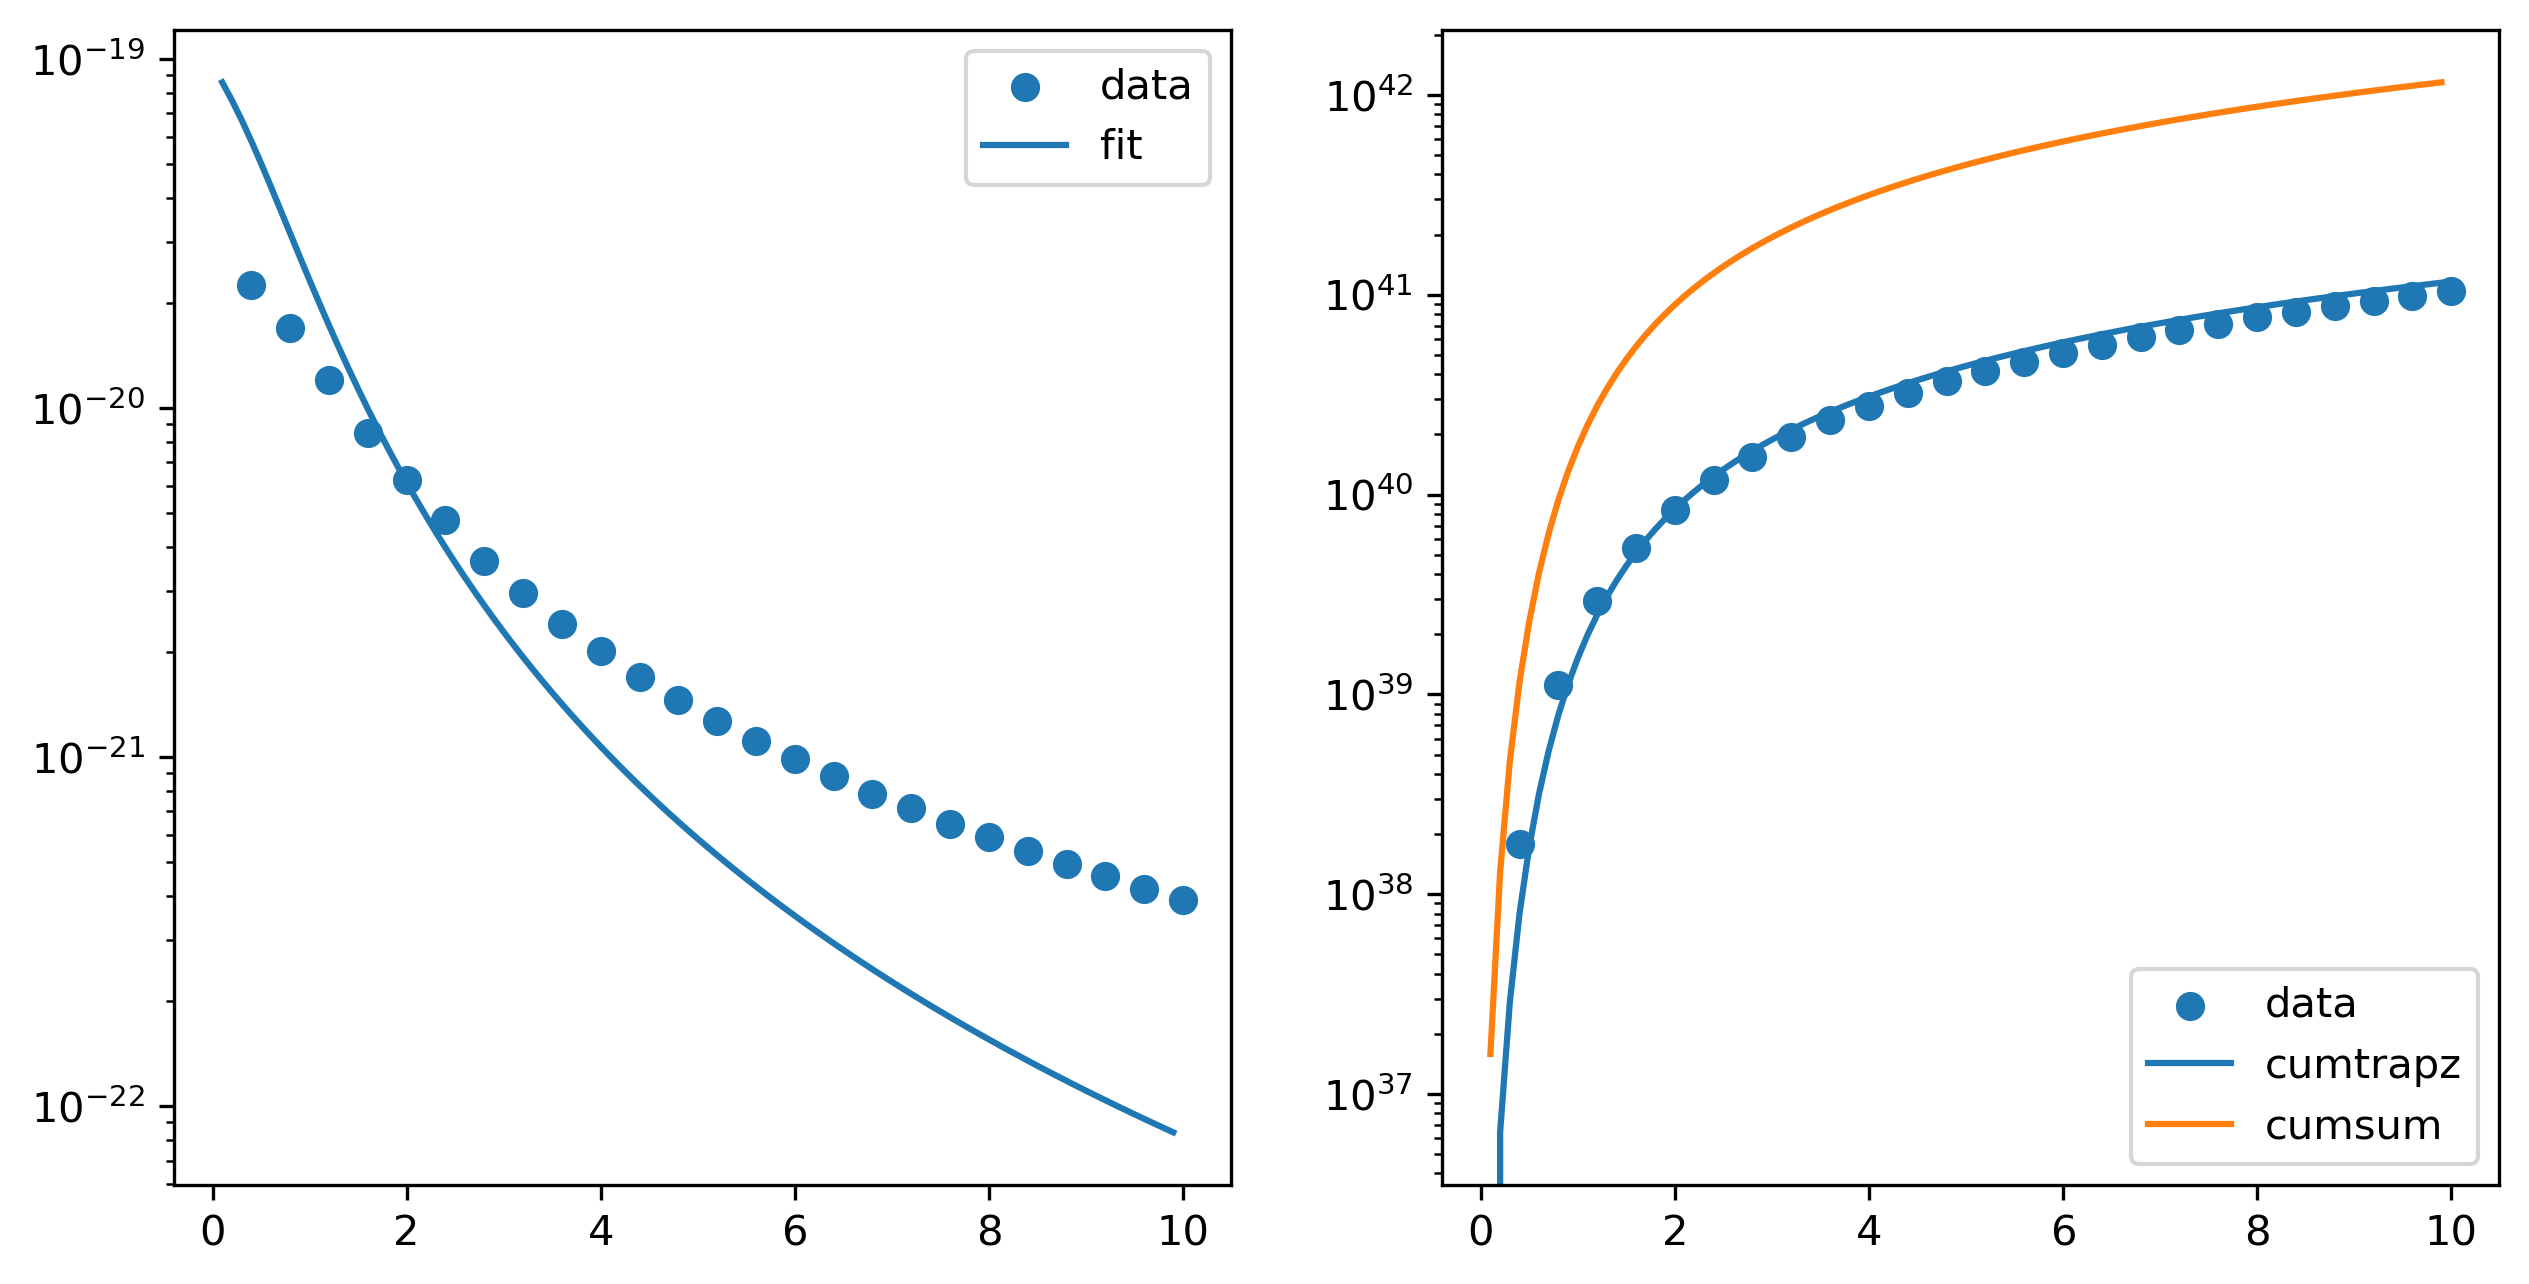

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

vh_scaled, r0 = 2.716, 0.983

def generate_rho_distrib_parts_cum(data):
    masses, distances = data[0], data[1]
    # print(masses)
    masses_cum = np.array([(np.sum(masses[distances < distance_bins[i]])).to(u.kg).value for i in range(1,
                  len(distance_bins))]) * u.kg
    
    return masses_cum / (4/3 * np.pi * distance_bins[1:]**3).to(u.m**3)

def integrate_func(R, parameters):
    return 2 * np.pi * ((R*u.kpc).to(u.m))**2 * (R*u.kpc).to(u.m) * rho_burkert(R, parameters)

def rho_burkert_cum(R, parameters):
    # return np.cumsum(integrate_func(R, parameters))
    return cumtrapz(integrate_func(R,parameters), R, initial=0)

def rho_burkert_cum_2(R, parameters):
    # return 2 * np.pi * ((R*u.kpc).to(u.m))**2 * np.cumsum(rho_burkert(R, parameters))
    return np.cumsum(integrate_func(R, parameters))

axes[0].scatter(distance_bins[1:], binned_parts[quant], label="data")
axes[0].plot(np.arange(0.1,10,0.1), rho_burkert(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="fit")
axes[0].set_yscale("log")

axes[0].legend()

axes[1].scatter(distance_bins[1:], np.mean(sampled_densities, axis=0), label="data")
axes[1].plot(np.arange(0.1,10,0.1), rho_burkert_cum(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="cumtrapz")
axes[1].plot(np.arange(0.1,10,0.1), rho_burkert_cum_2(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="cumsum")
axes[1].set_yscale("log")

axes[1].legend()
plt.show()

In [280]:
mcmc_dict["NFW"] = run_mcmc(distance_bins, binned_cubes[quant], quant,
                            "NFW", rho_NFW_cum, lnprior_NFW, lnprob_NFW, 
                            [r'$\rho_{0,h}$', r'$r_h$'], 
                            initial_guess = [2.0,1.1], 
                            nwalkers=60, nsteps=1000, burnout=int(0.4*1000))

# mcmc_dict["burkert"] = run_mcmc(distance_bins, np.mean(sampled_densities, axis=0)*u.kg/u.m**3, quant, errors[quant],
#                                 "burkert", rho_burkert_cum, lnprior_burkert, lnprob_burkert, 
#                                 ["$v_h$ [km$\cdot$(100s)$^{-1}$]", "$r_0$ [kpc]"], 
#                                 initial_guess = [6,5], 
#                                 nwalkers=20, nsteps=4000, burnout=int(0.4*4000))

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood f

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/conda/lib/p

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

AttributeError: 'numpy.ndarray' object has no attribute 'value'
AttributeError: 'numpy.ndarray' object has no attribute 'value'


emcee: Exception while calling your likelihood function:

AttributeError: 'numpy.ndarray' object has no attribute 'value'


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood f

Traceback (most recent call last):









  exception:





Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/conda/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call la

AttributeError: 'numpy.ndarray' object has no attribute 'value'

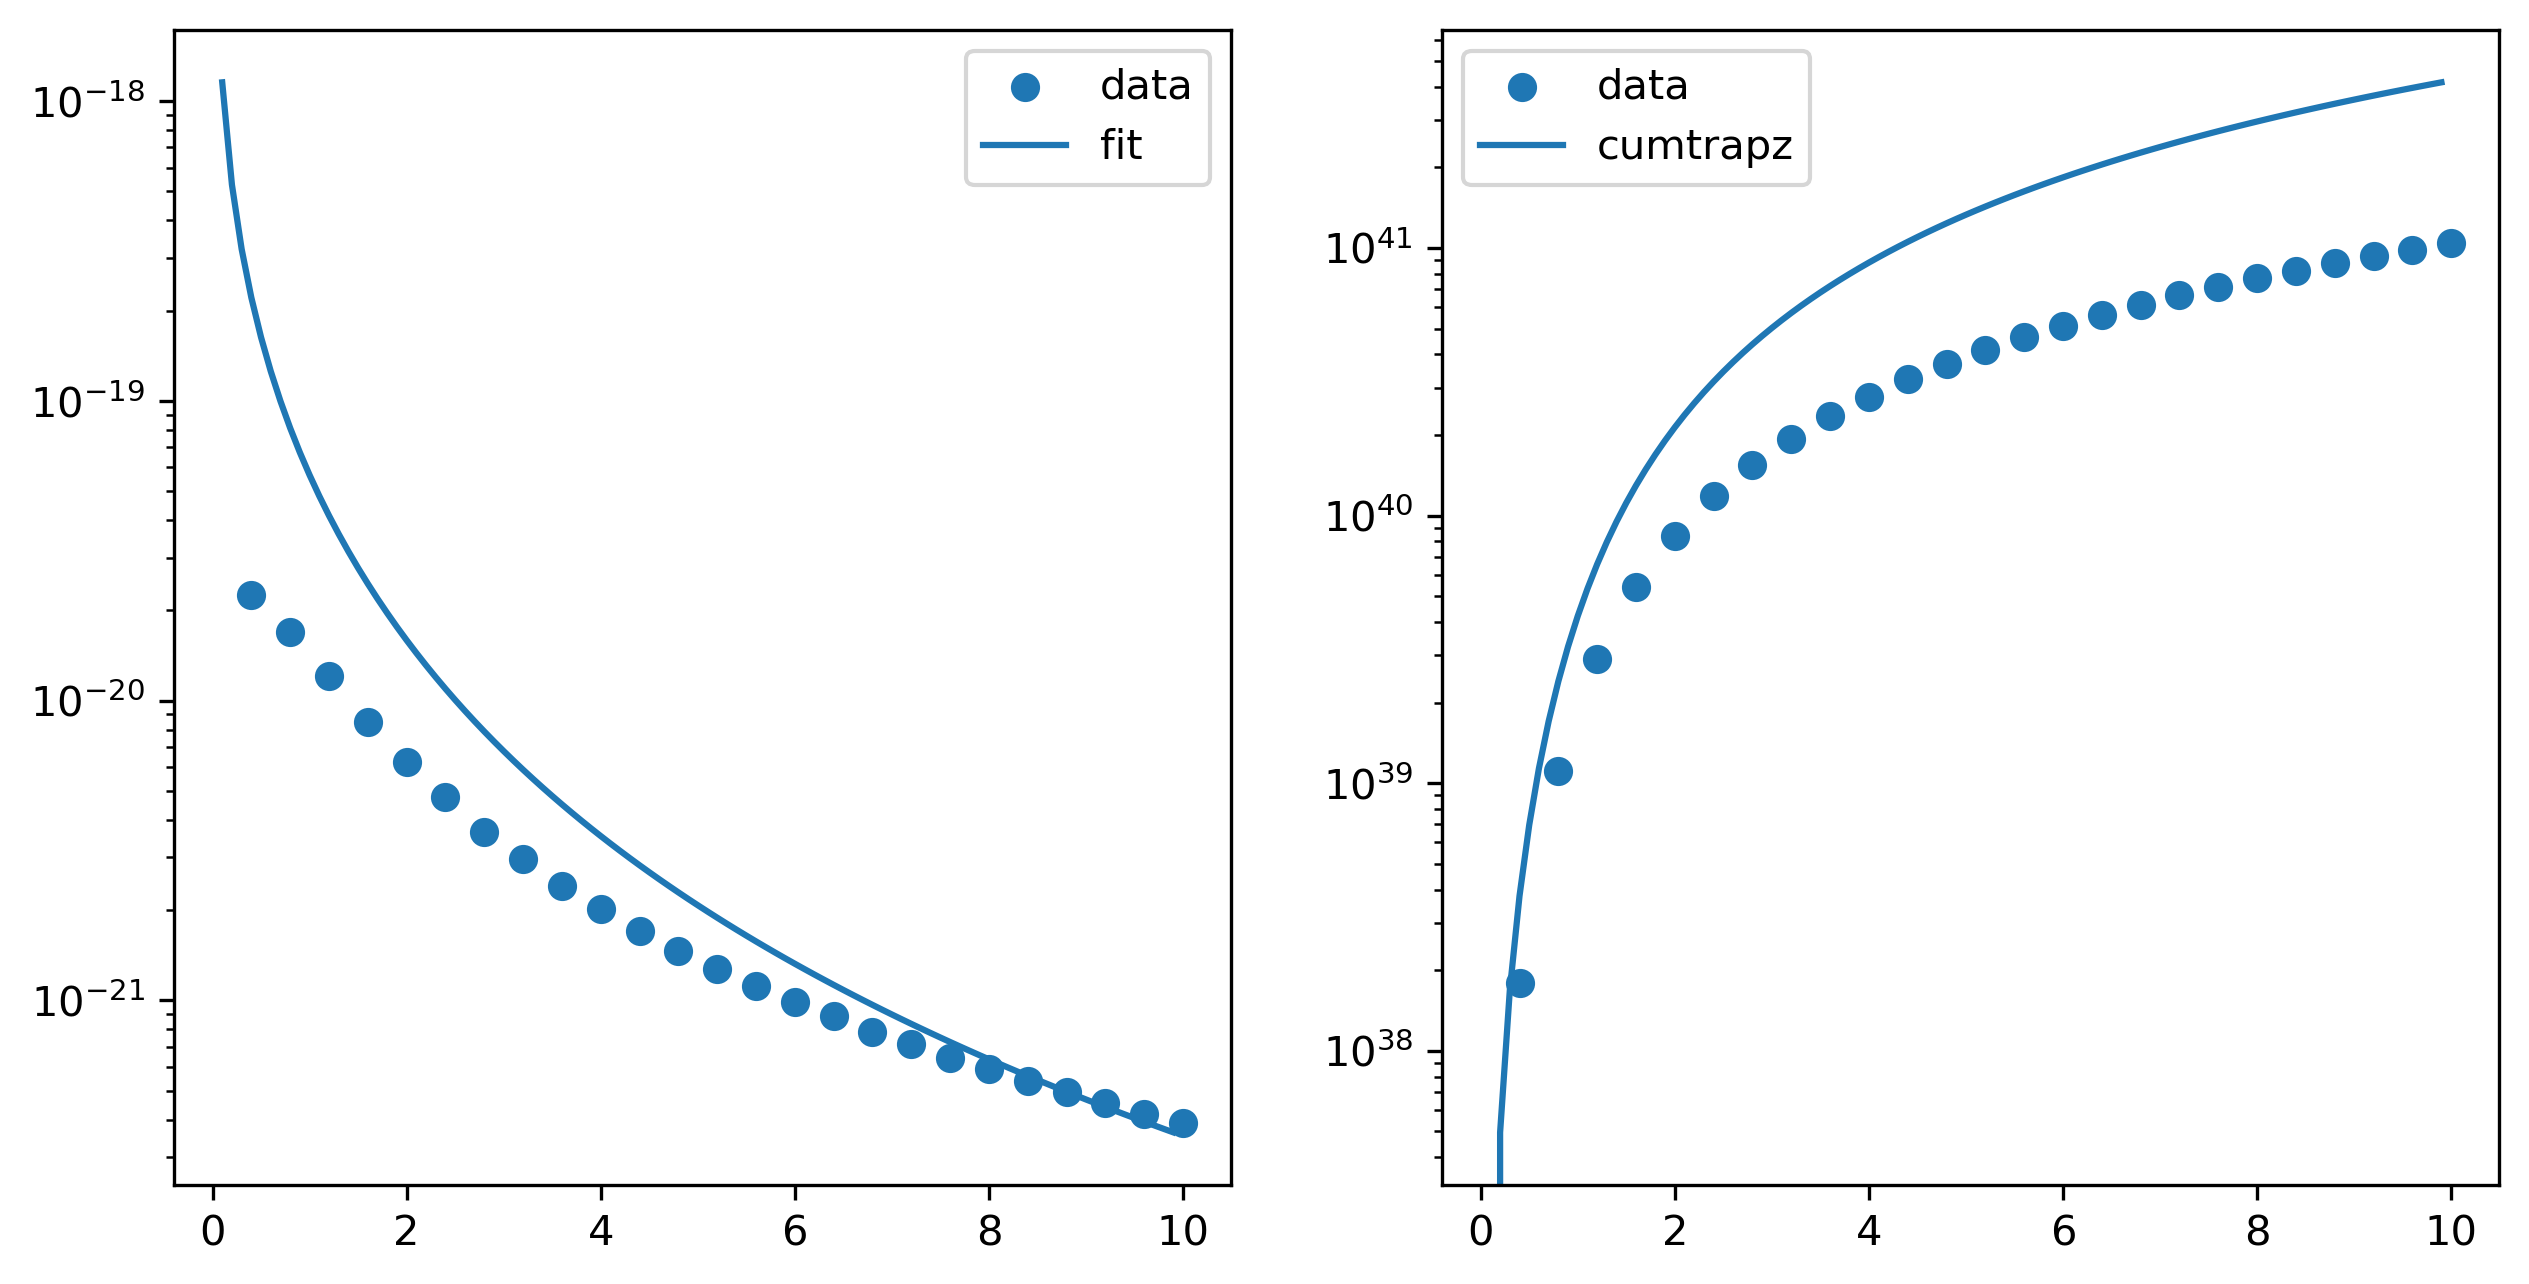

In [273]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

vh_scaled, r0 = 94, 0.2

axes[0].scatter(distance_bins[1:], binned_parts[quant], label="data")
axes[0].plot(np.arange(0.1,10,0.1), rho_NFW(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="fit")
axes[0].set_yscale("log")

axes[0].legend()

axes[1].scatter(distance_bins[1:], np.mean(sampled_densities, axis=0), label="data")
axes[1].plot(np.arange(0.1,10,0.1), rho_NFW_cum(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="cumtrapz")
# axes[1].plot(np.arange(0.1,10,0.1), rho_NFW_2(np.arange(0.1,10,0.1), [vh_scaled, r0]), label="cumsum")
axes[1].set_yscale("log")

axes[1].legend()
plt.show()

In [251]:
mcmc_dict["gNFW"] = run_mcmc(distance_bins, binned_cubes[quant], quant, errors[quant],
                             "gNFW", rho_gNFW, lnprior_gNFW, lnprob_gNFW, 
                             [r'$\rho_s$', r'$r_s$', r'$\alpha$', r'$\beta$', r'$\gamma$'], 
                             initial_guess = [15,1.2,1,2,1], 
                             nwalkers=60, nsteps=10000, burnout=int(0.4*10000))

KeyError: 'dark_mat'

100%|██████████| 10000/10000 [06:38<00:00, 25.09it/s]


The constraints are:
$\rho_s$ = 0.6967006981730852 +- 0.15155007360242012
$r_s$ = 9.066272332663086 +- 1.5099296375504254
$\alpha$ = 0.2715563708384835 +- 0.03069417410651304



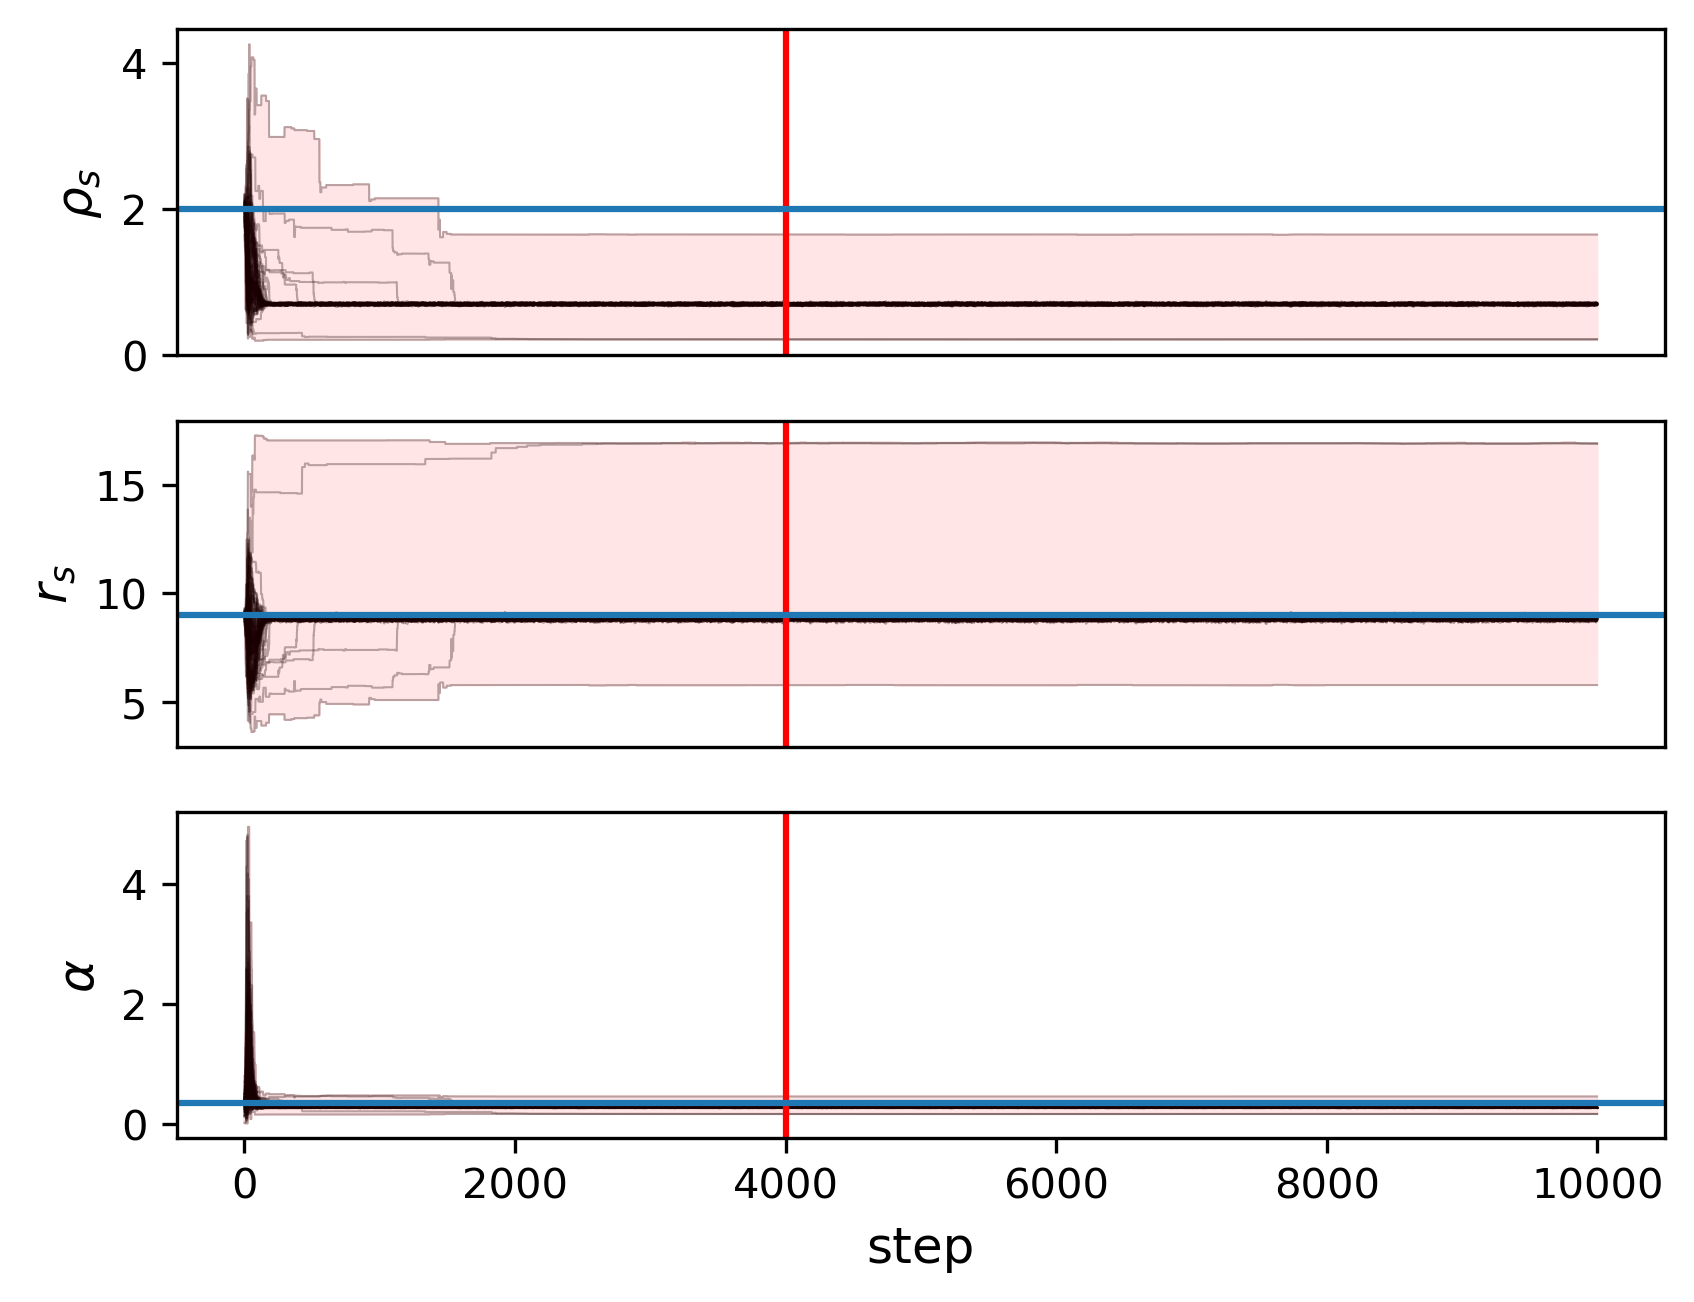

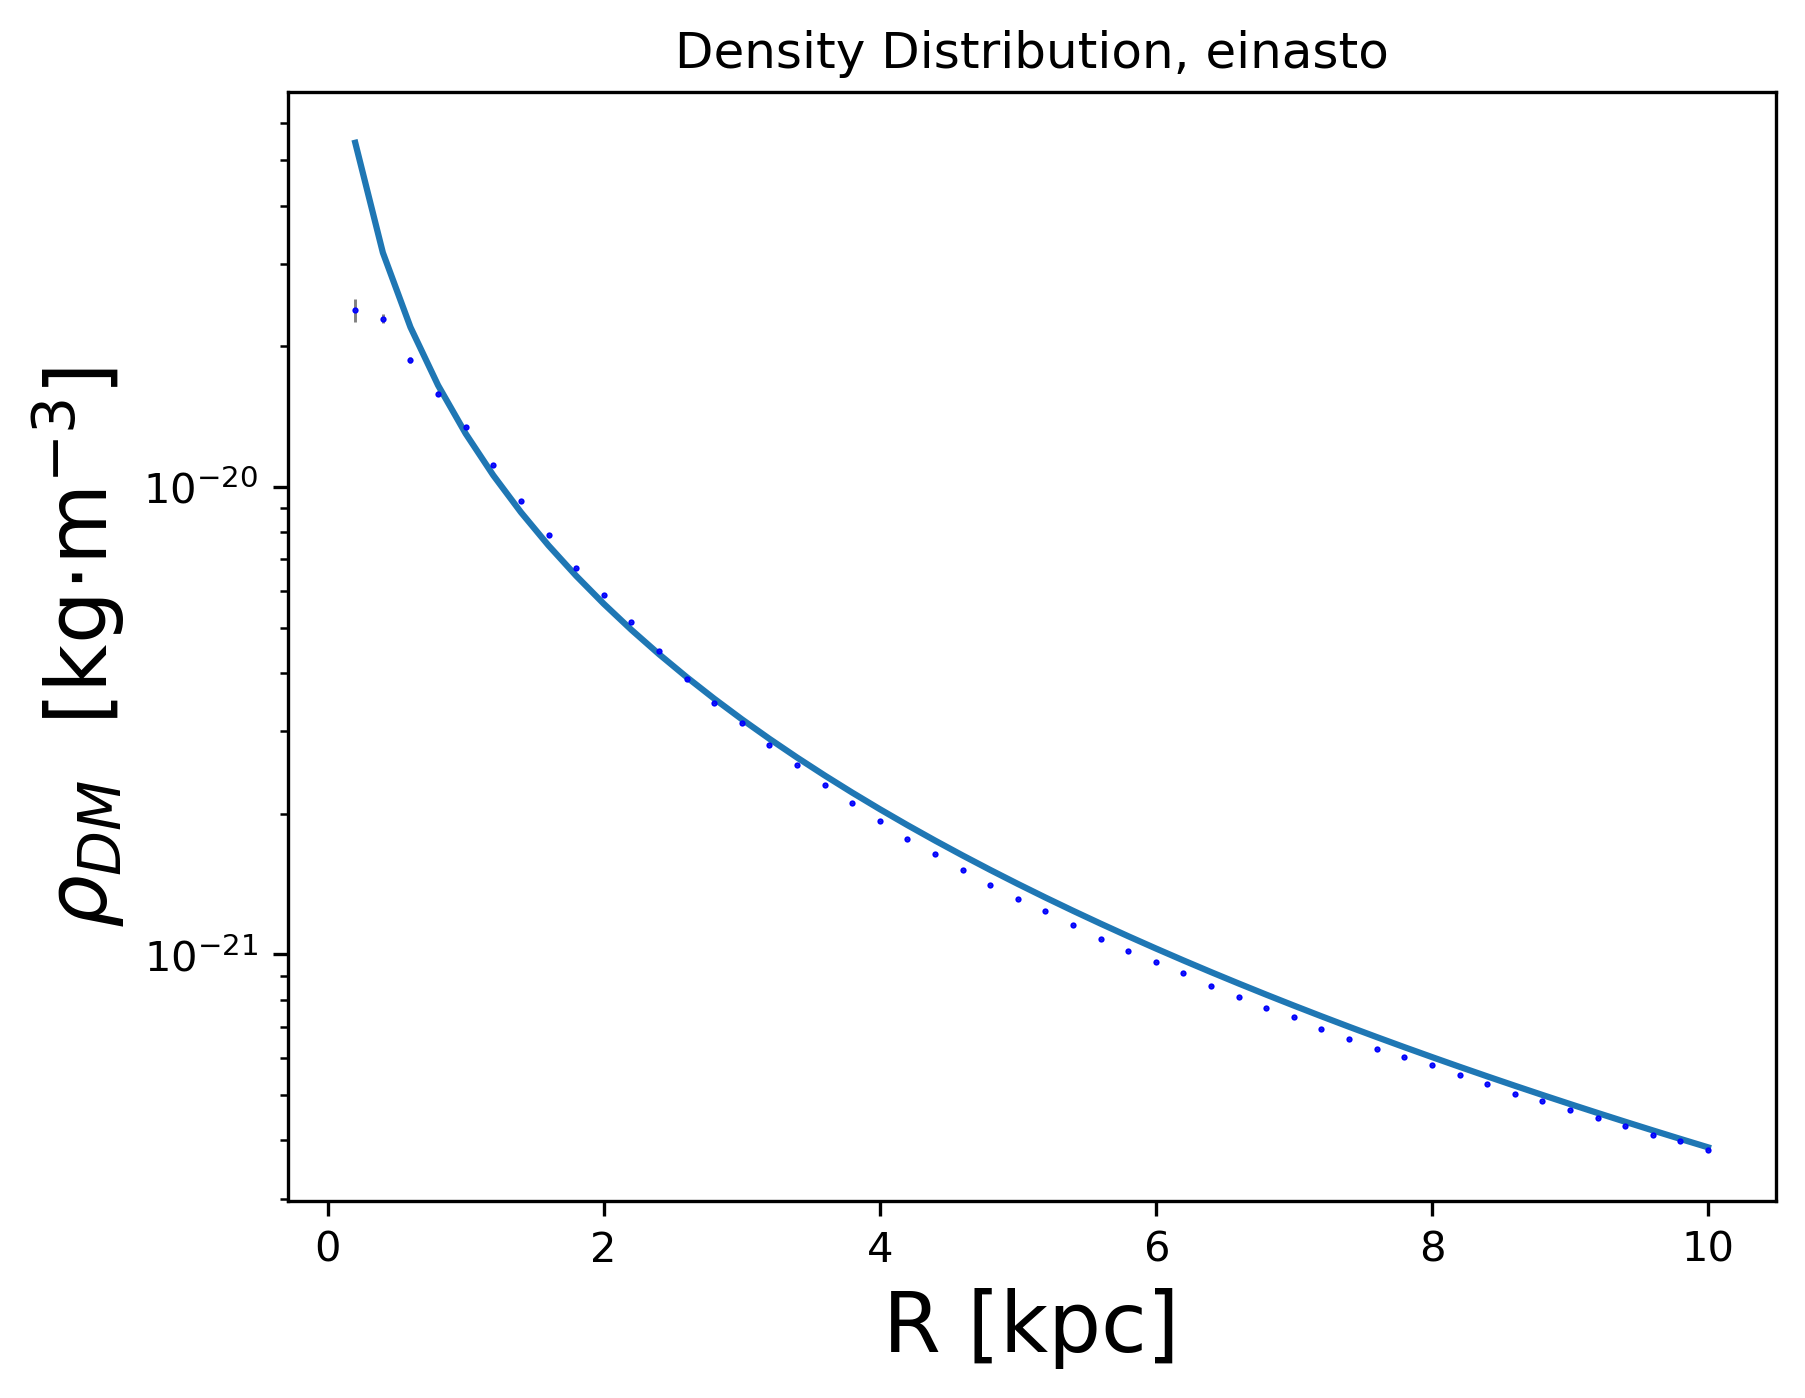

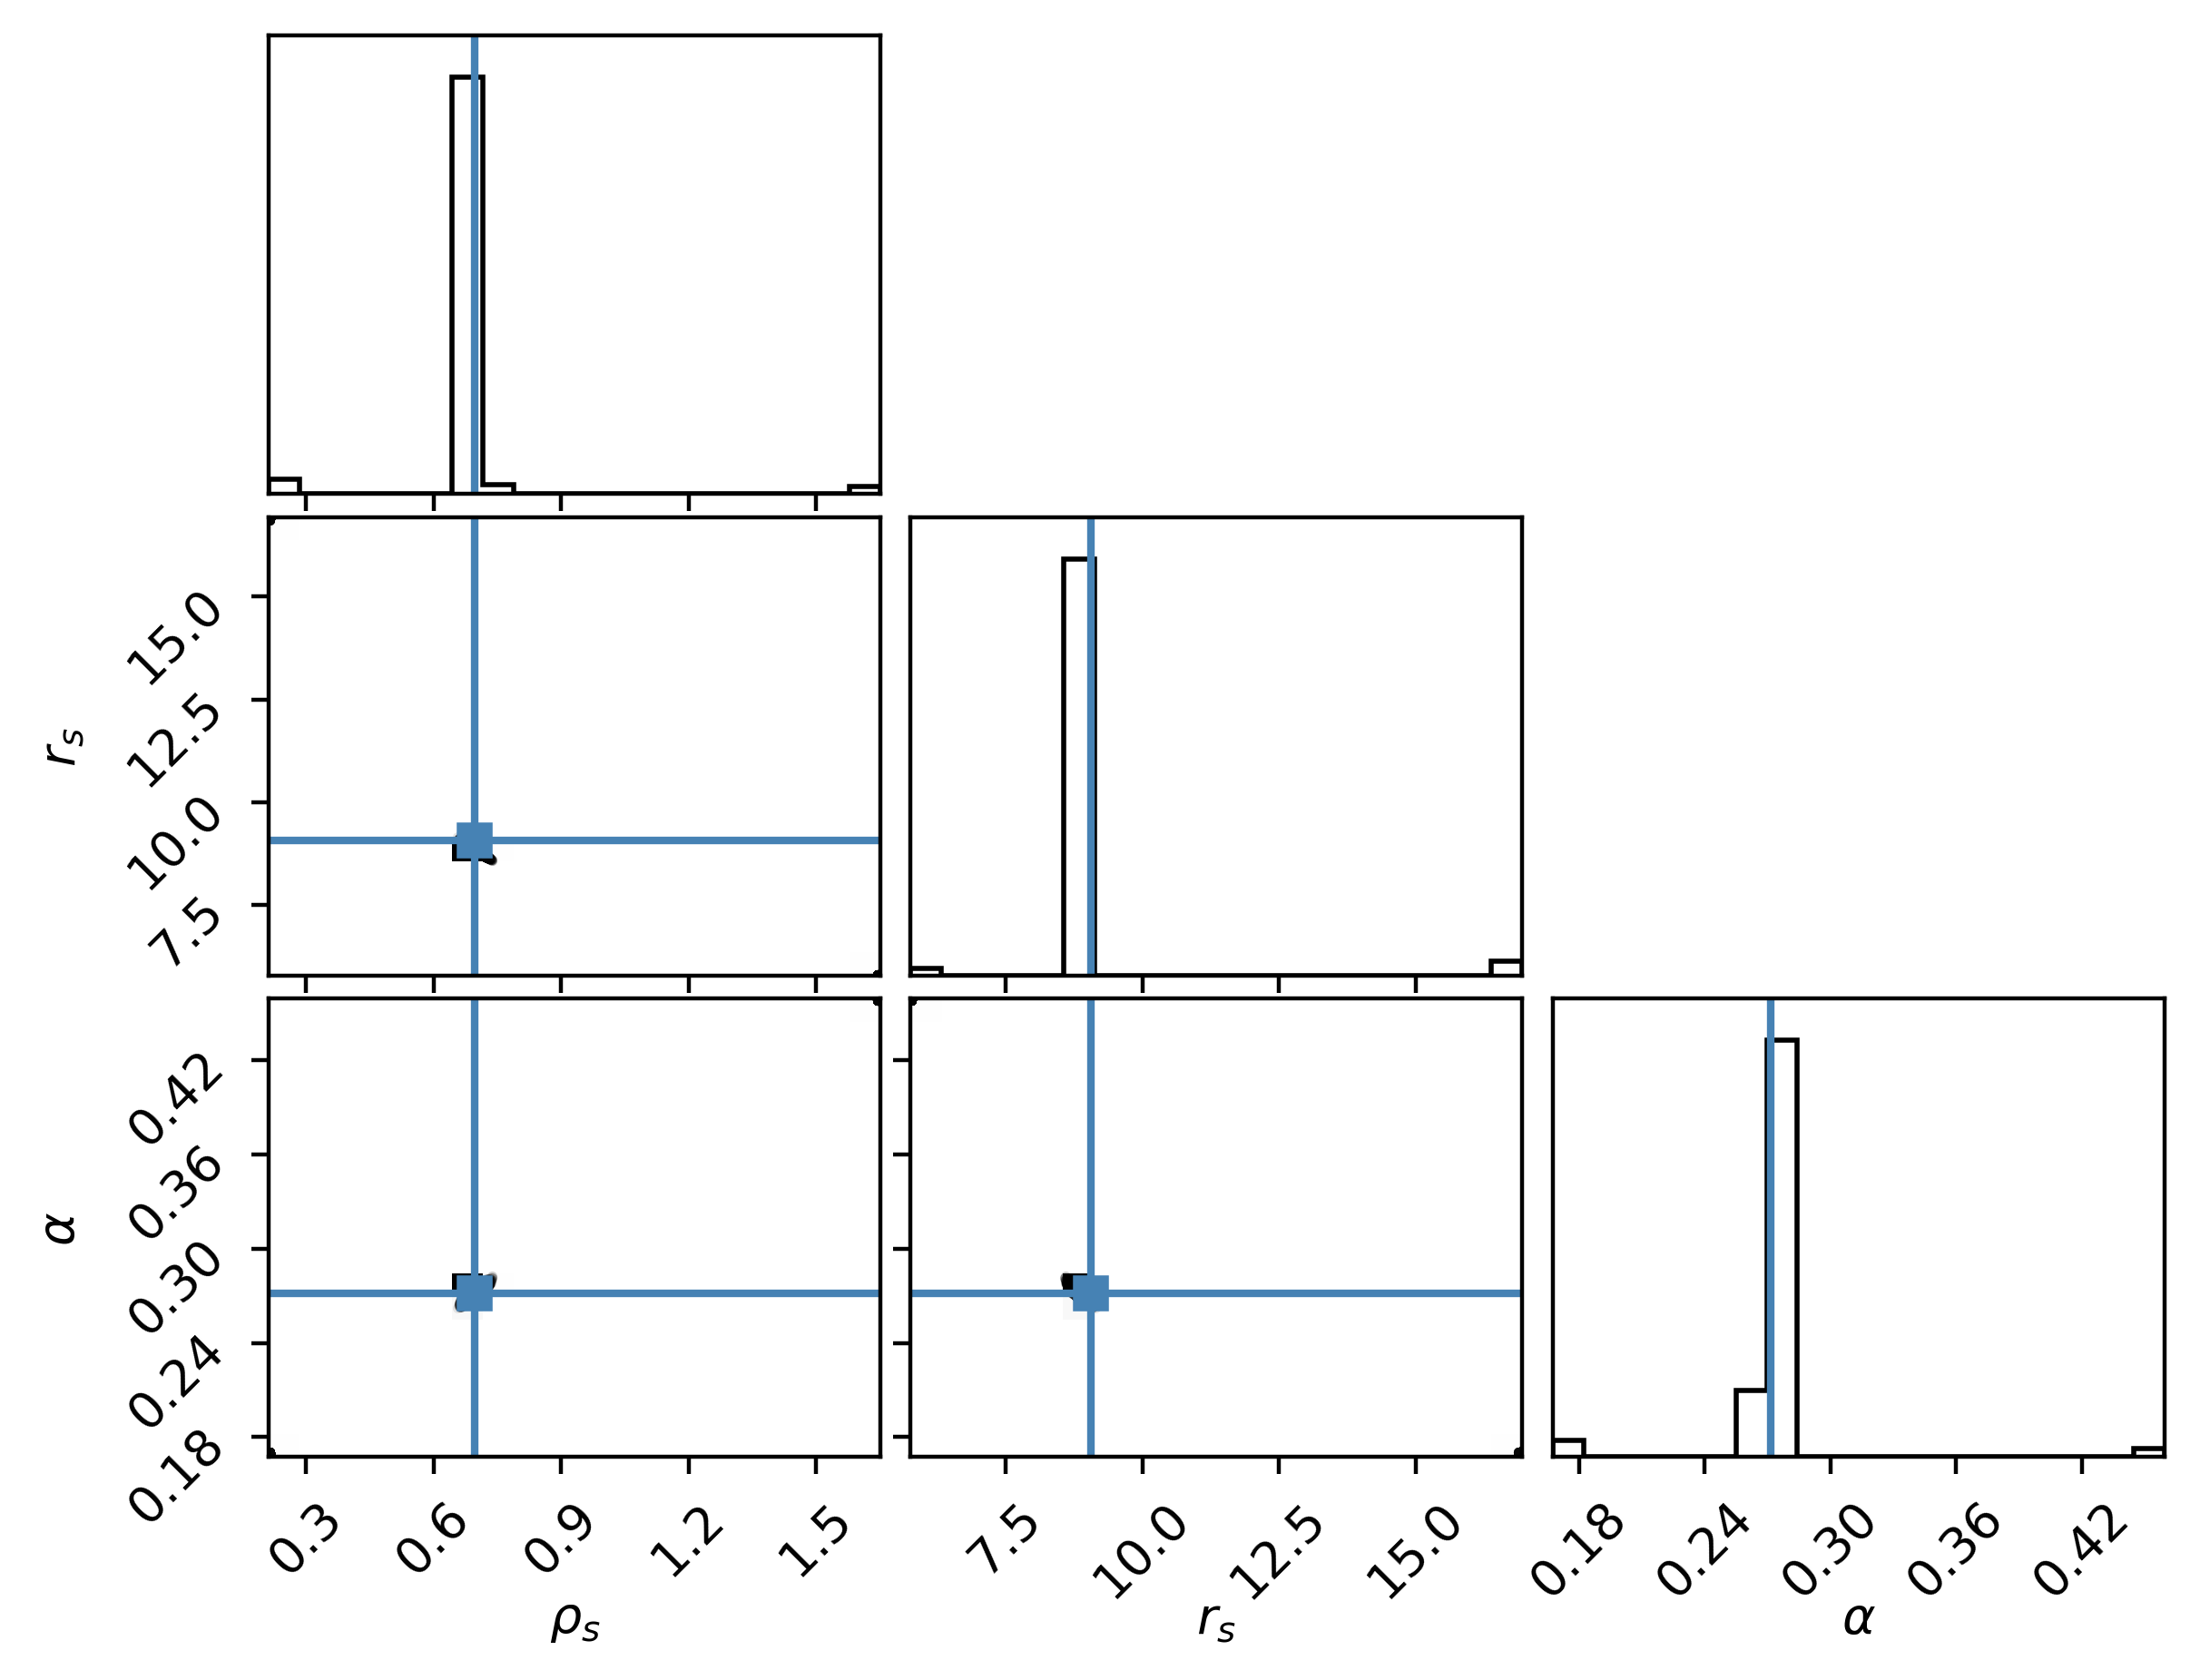

In [47]:
mcmc_dict["einasto"] = run_mcmc(distance_bins, binned_cubes[quant], quant, errors[quant],
                                "einasto", rho_Einasto, lnprior_Einasto, lnprob_Einasto, 
                                [r'$\rho_s$', r'$r_s$', r'$\alpha$'], 
                                initial_guess = [2,9,0.35], 
                                nwalkers=60, nsteps=10000, burnout=int(0.4*10000))

100%|██████████| 1000/1000 [00:08<00:00, 116.24it/s]


The constraints are:
$\rho_s$ = 1.0768333131272367 +- 0.20563196569852746
$r_s$ = 7.159501382267739 +- 0.6890053081596215
$\alpha$ = 0.25162378893544773 +- 0.006934216357160339
$\gamma$ = -0.1166267640591101 +- 0.04808194965119602



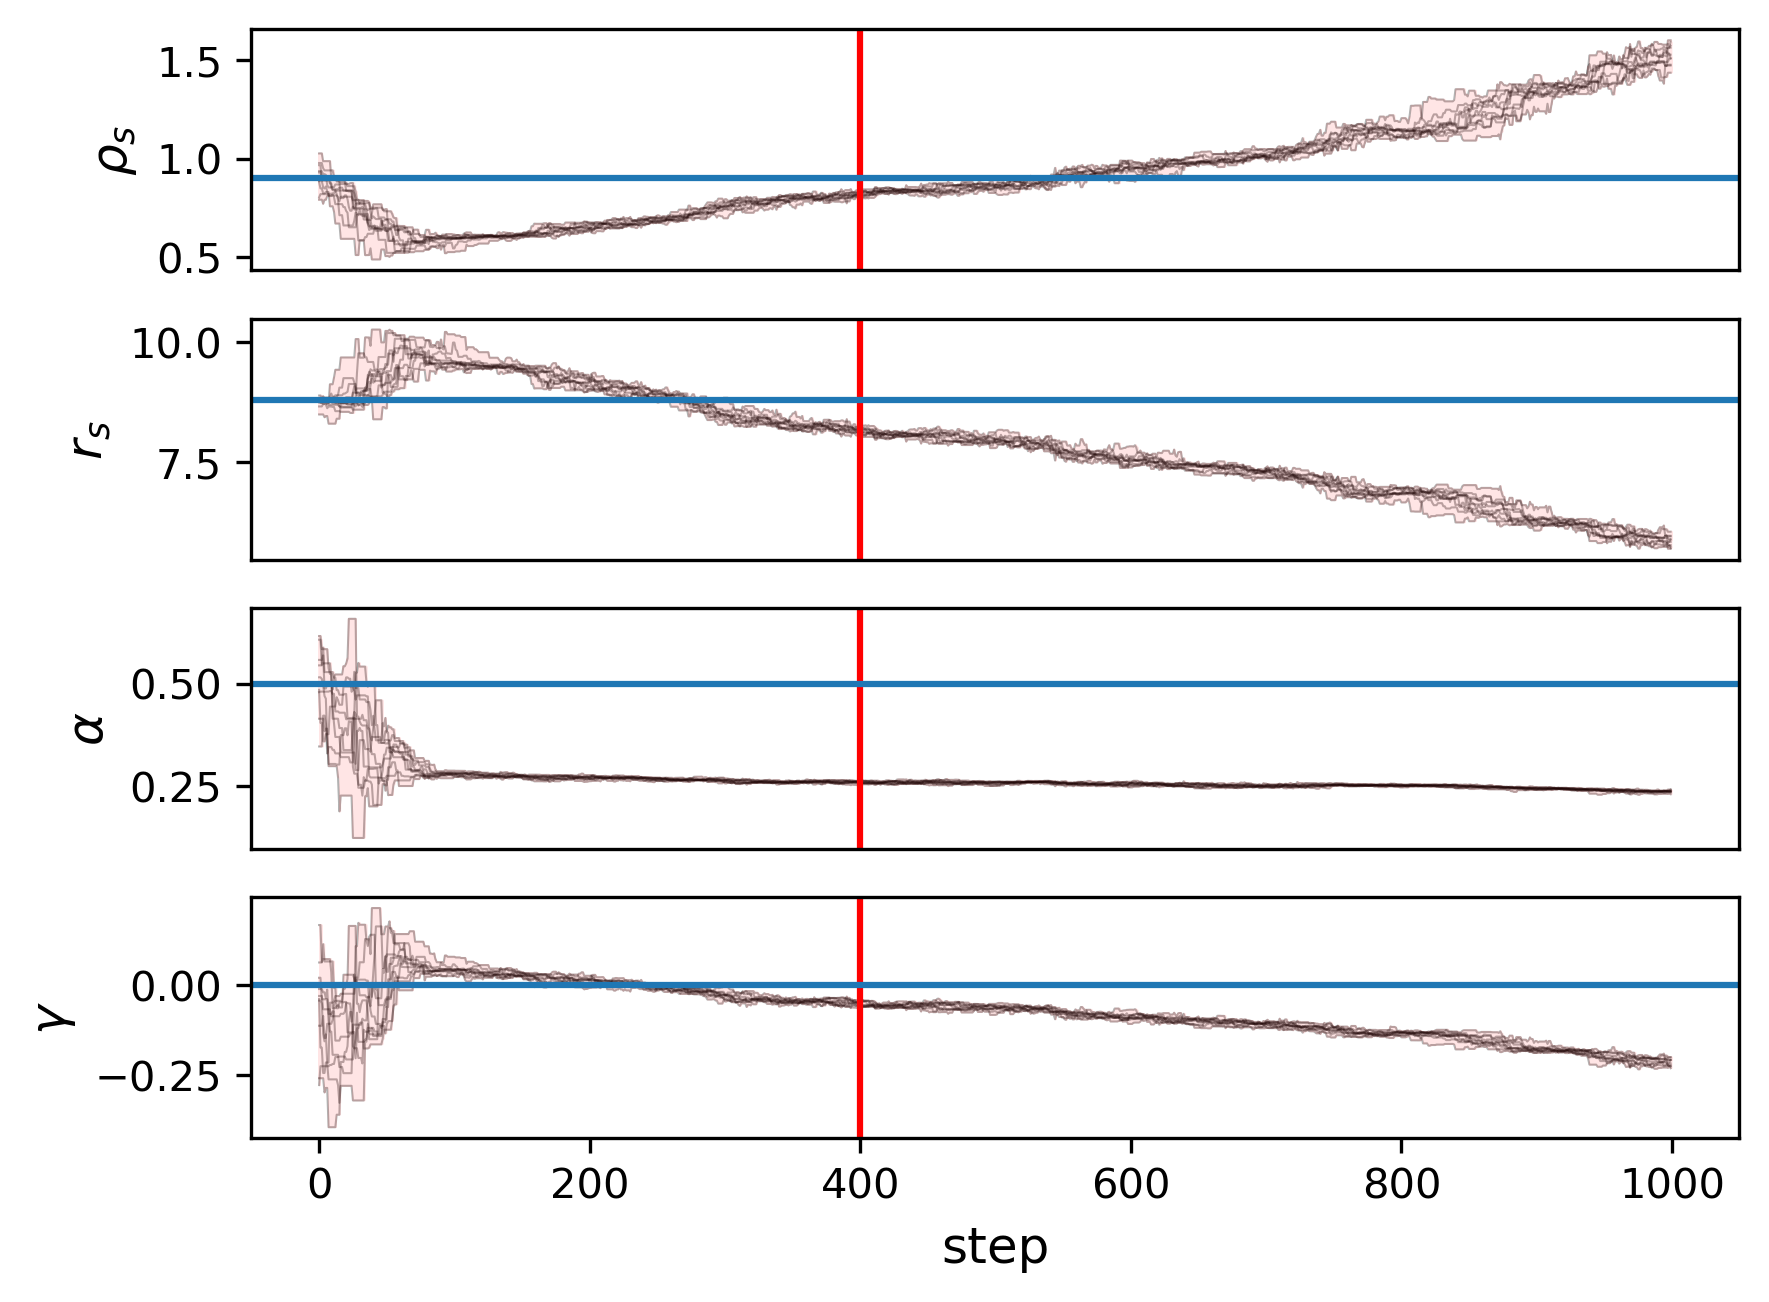

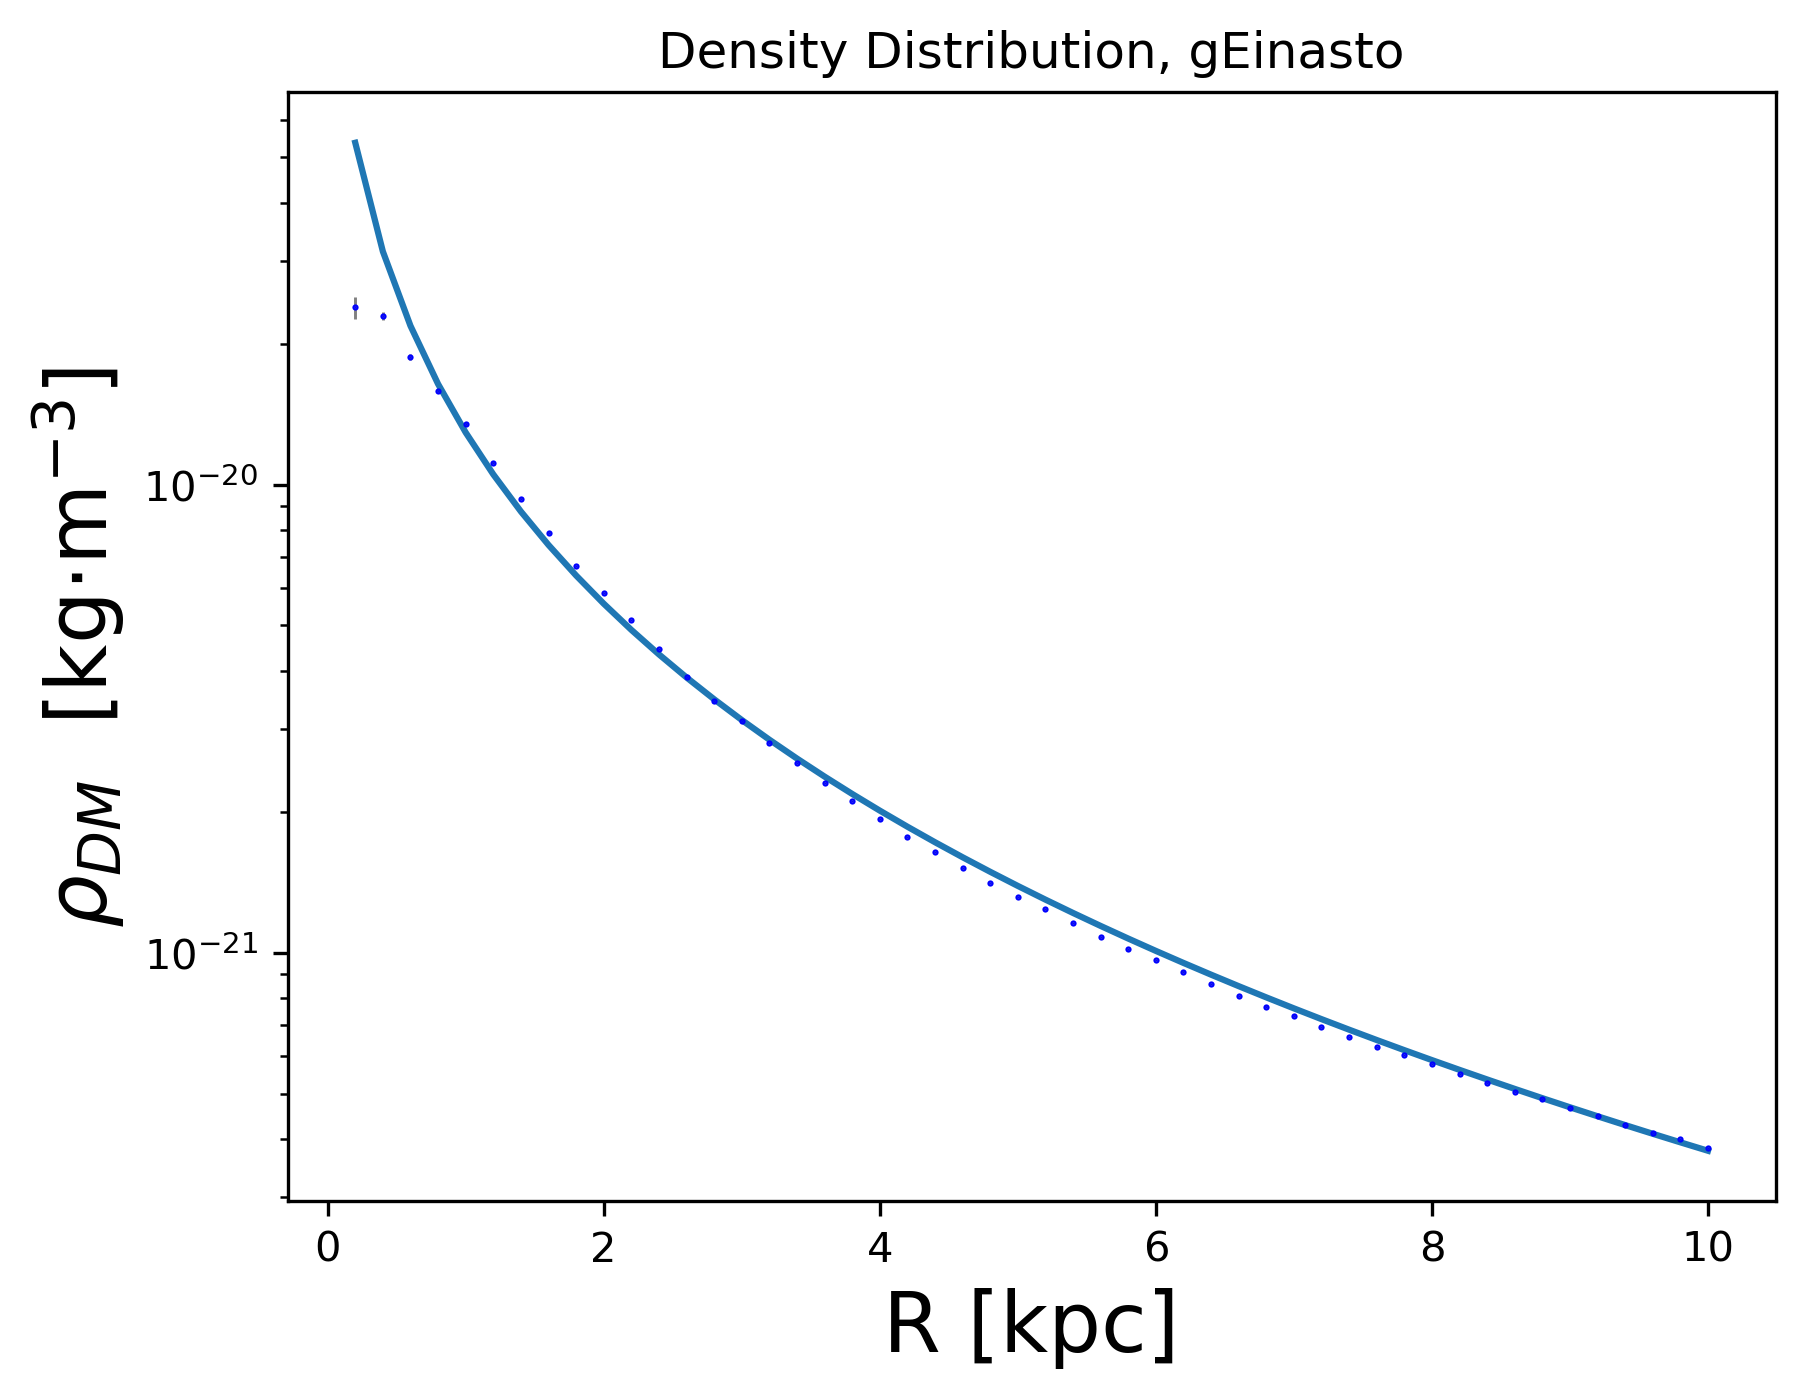

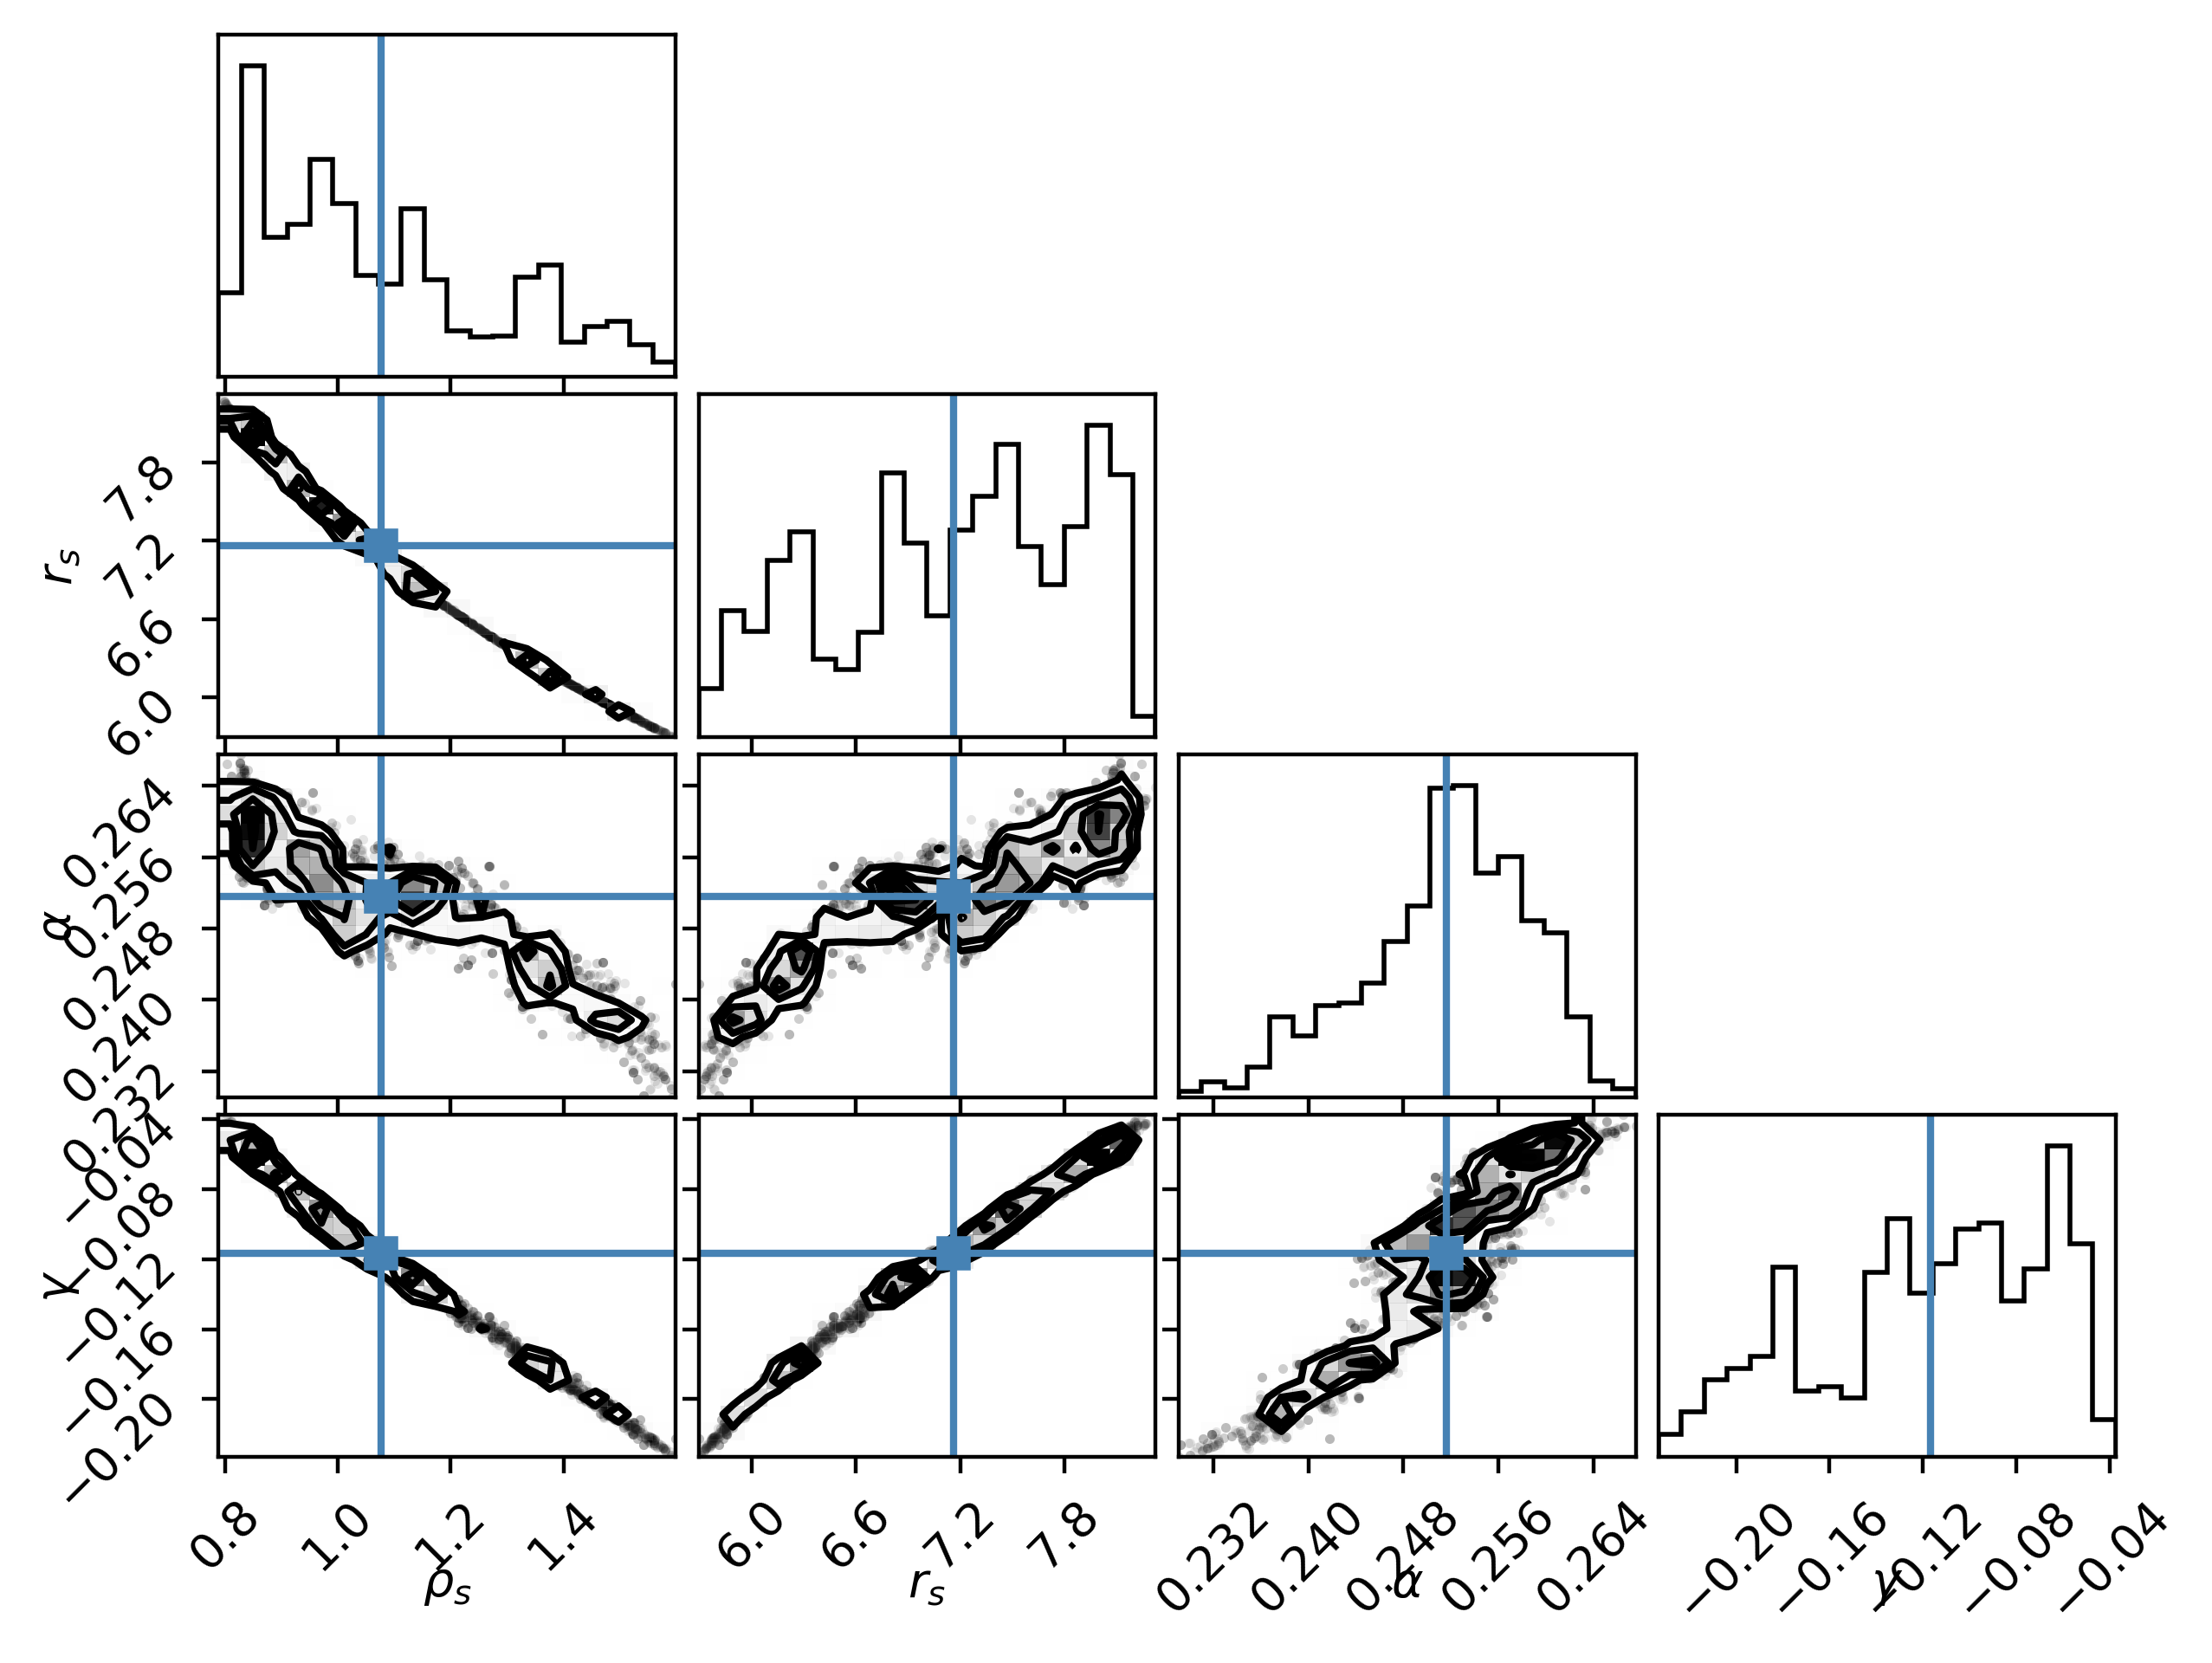

In [50]:
mcmc_dict["geinasto"] = run_mcmc(distance_bins, binned_cubes[quant], quant, errors[quant], 
                                 "gEinasto", rho_gEinasto, lnprior_gEinasto, lnprob_gEinasto, 
                                 [r'$\rho_s$', r'$r_s$', r'$\alpha$', r'$\gamma$'], 
                                 initial_guess = [0.9,8.8,0.5,0], 
                                 nwalkers=10, nsteps=1000, burnout=int(0.4*1000))
# mcmc_dict["geinasto"] = run_mcmc(distance_bins, binned_cubes[quant], quant, errors[quant], 
#                                  "gEinasto", rho_gEinasto, lnprior_gEinasto, lnprob_gEinasto, 
#                                  [r'$\rho_s$', r'$r_s$', r'$\alpha$', r'$\gamma$'], 
#                                  initial_guess = [0.9,8.8,0.5,0], 
#                                  nwalkers=10000, nsteps=100000, burnout=int(0.4*100000))

In [8]:
# beta = 1
# gamma = 1
# alpha = 2
# R_kpc = 1*u.kpc
# r_s_kpc = 19 * u.kpc

# rho_s_kg_m3 = (1.06e7 * u.solMass / u.kpc**3).to(u.kg/u.m**3)

# ( rho_s_kg_m3 ) / ( (R_kpc/r_s_kpc) * (1+(R_kpc/r_s_kpc)**alpha)**((beta - gamma)/alpha)  )

In [15]:
# rho_s_kg_m3 / ((R_kpc/r_s_kpc)*(1+R_kpc/r_s_kpc)**2)

<Quantity 1.23015816e-20 kg / m3>

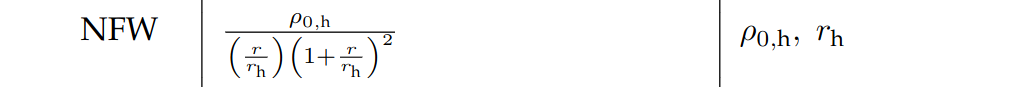

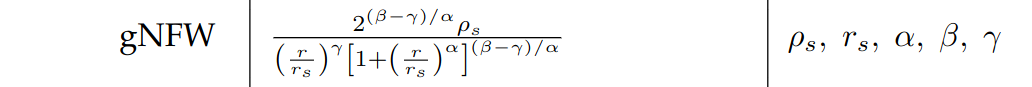

In [44]:
# plt.figure(dpi=300)
# plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_NFW(R_outer.value, [1,1.9]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Density Distribution, ")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# # plt.savefig("plots/"+model_name+"-fit.png", bbox_inches='tight')
# plt.show()

In [43]:
# import corner
# corner_fig = plt.figure(dpi=400)
# corner.corner(
#     analysis_chain, labels=["$v_h$ [km$\cdot$(100s)$^{-1}$]", "$r_0$ [kpc]"], truths=posterior_means, fig=corner_fig
# );

In [9]:
# plt.figure(dpi=300)
# plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_gNFW(R_outer.value, [5e7,4,0.8,2,1]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Density Distribution, ")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# # plt.savefig("plots/"+model_name+"-fit.png", bbox_inches='tight')
# plt.show()

In [ ]:
# analysis_chain[:,0][analysis_chain[:,0]<2] = 2.18
# analysis_chain[:,1][analysis_chain[:,1]>1.10] = 1.0

# posterior_means = np.average(np.array(analysis_chain),axis=0)

# import corner
# corner_fig = plt.figure(dpi=400)
# corner.corner(
#     analysis_chain, labels=["$v_h$ [km$\cdot$(100s)$^{-1}$]", "$r_0$ [kpc]"], truths=posterior_means, fig=corner_fig
# );

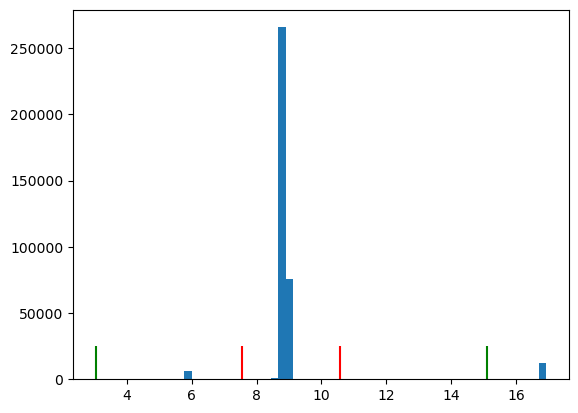

In [48]:
plt.hist(mcmc_dict["einasto"][0][:,1], bins = 50)
plt.vlines(np.average(mcmc_dict["einasto"][0][:,1]) + np.std(mcmc_dict["einasto"][0][:,1]),0,25000, "r")
plt.vlines(np.average(mcmc_dict["einasto"][0][:,1]) - np.std(mcmc_dict["einasto"][0][:,1]),0,25000, "r")
plt.vlines(np.average(mcmc_dict["einasto"][0][:,1]) + 4*np.std(mcmc_dict["einasto"][0][:,1]),0,25000, "g")
plt.vlines(np.average(mcmc_dict["einasto"][0][:,1]) - 4*np.std(mcmc_dict["einasto"][0][:,1]),0,25000, "g")
plt.show()

100%|██████████| 100000/100000 [1:30:46<00:00, 18.36it/s]


The constraints are:
$\rho_s$ = 63.65171886883086 +- 26.24768603184808
$r_s$ = 0.23690215098069106 +- 0.7688337869833479
$\alpha$ = 0.1246020418608081 +- 0.026654092631187395
$\gamma$ = -2.0284676321192743 +- 0.5639727728529588



100%|██████████| 50000/50000 [05:04<00:00, 164.38it/s]


The constraints are:
$\rho_s$=54048+-2897
$\rho_s$=540483419.7531289+-289706899.6908305
$r_s$=0.497+-0.67
$r_s$=0.497198330920032+-0.6758613917911572
$\alpha$=0.149+-0.02
$\alpha$=0.1492692531164264+-0.026601732937970836
$\gamma$=-1.49+-0.49
$\gamma$=-1.4967346577516192+-0.49045247519751006



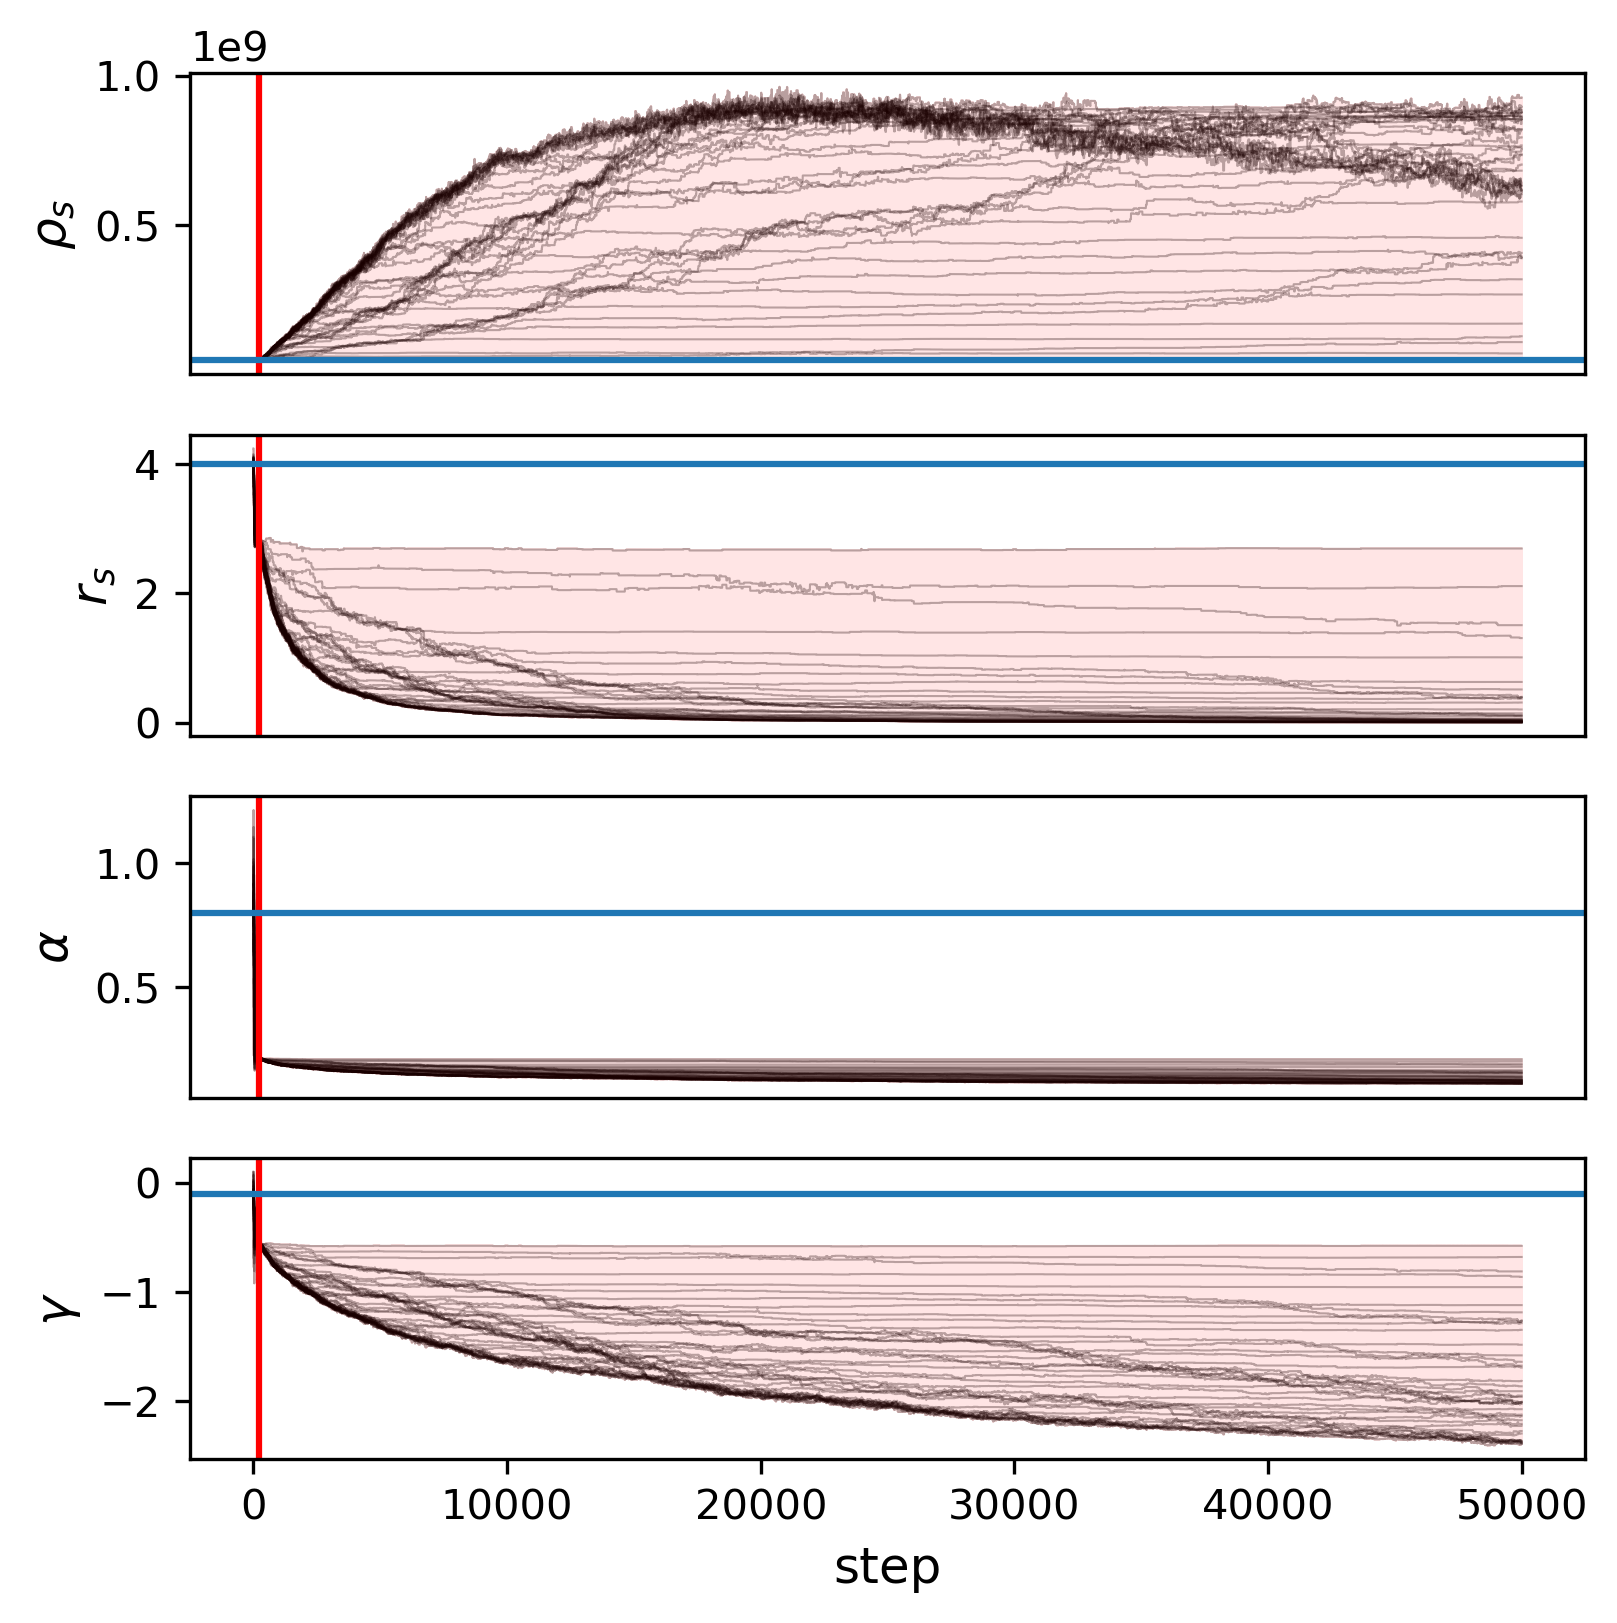

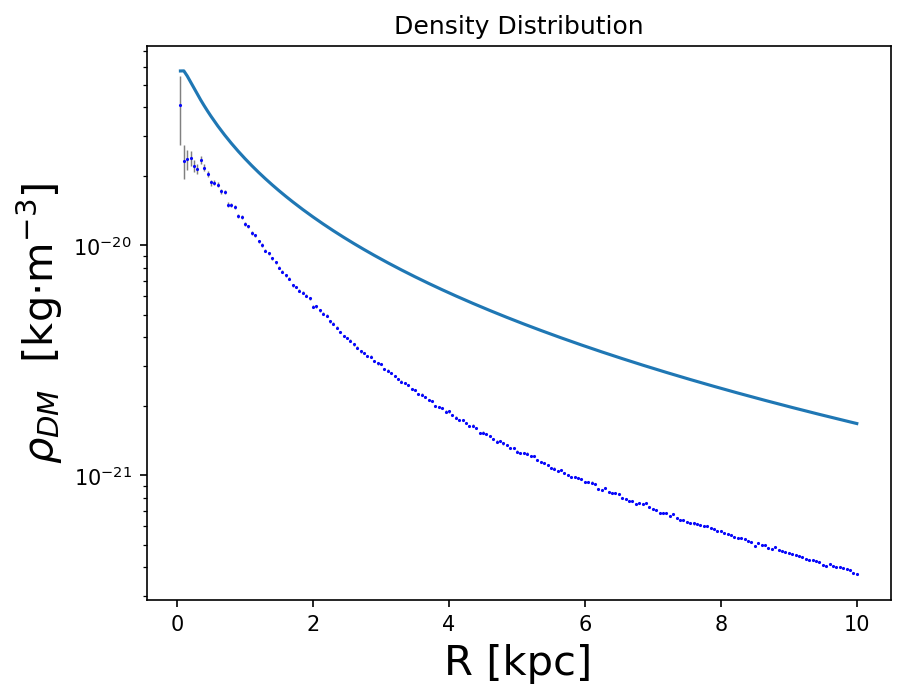

In [146]:
# run_mcmc(rho_burkert, lnprior_burkert, lnprob_burkert, ["$v_h$ [km$\cdot$s$^{-1}$]", "$r_0$ [kpc]"], 
#          initial_guess = [vh, r0], nwalkers=20, nsteps=500, burnout=int(0.4*nsteps))
# [r'$\rho_s$ [M$_\circ\cdot$kpc$^{-3}$]', r'$r_s$ [kpc]', r'$\alpha$', r'$\gamma$'] # [1e7,7.25,0.274,-0.1]
run_mcmc("gEinasto", rho_gEinasto, lnprior_gEinasto, lnprob_gEinasto, [r'$\rho_s$', r'$r_s$', r'$\alpha$', r'$\gamma$'], 
         initial_guess = [5e7,4,0.8,-0.1], nwalkers=40, nsteps=50000, burnout=int(0.4*nsteps))  

100%|██████████| 80000/80000 [14:17<00:00, 93.30it/s] 


The constraints are:
$\rho_s$=56497+-2418
$\rho_s$=564977264.1313176+-241813472.18989342
$r_s$=0.273+-0.51
$r_s$=0.2732255912796781+-0.514573962995411
$\alpha$=0.134+-0.02
$\alpha$=0.1345444036738457+-0.026098786162939435
$\gamma$=-1.84+-0.56
$\gamma$=-1.842647882923136+-0.5630205959642612



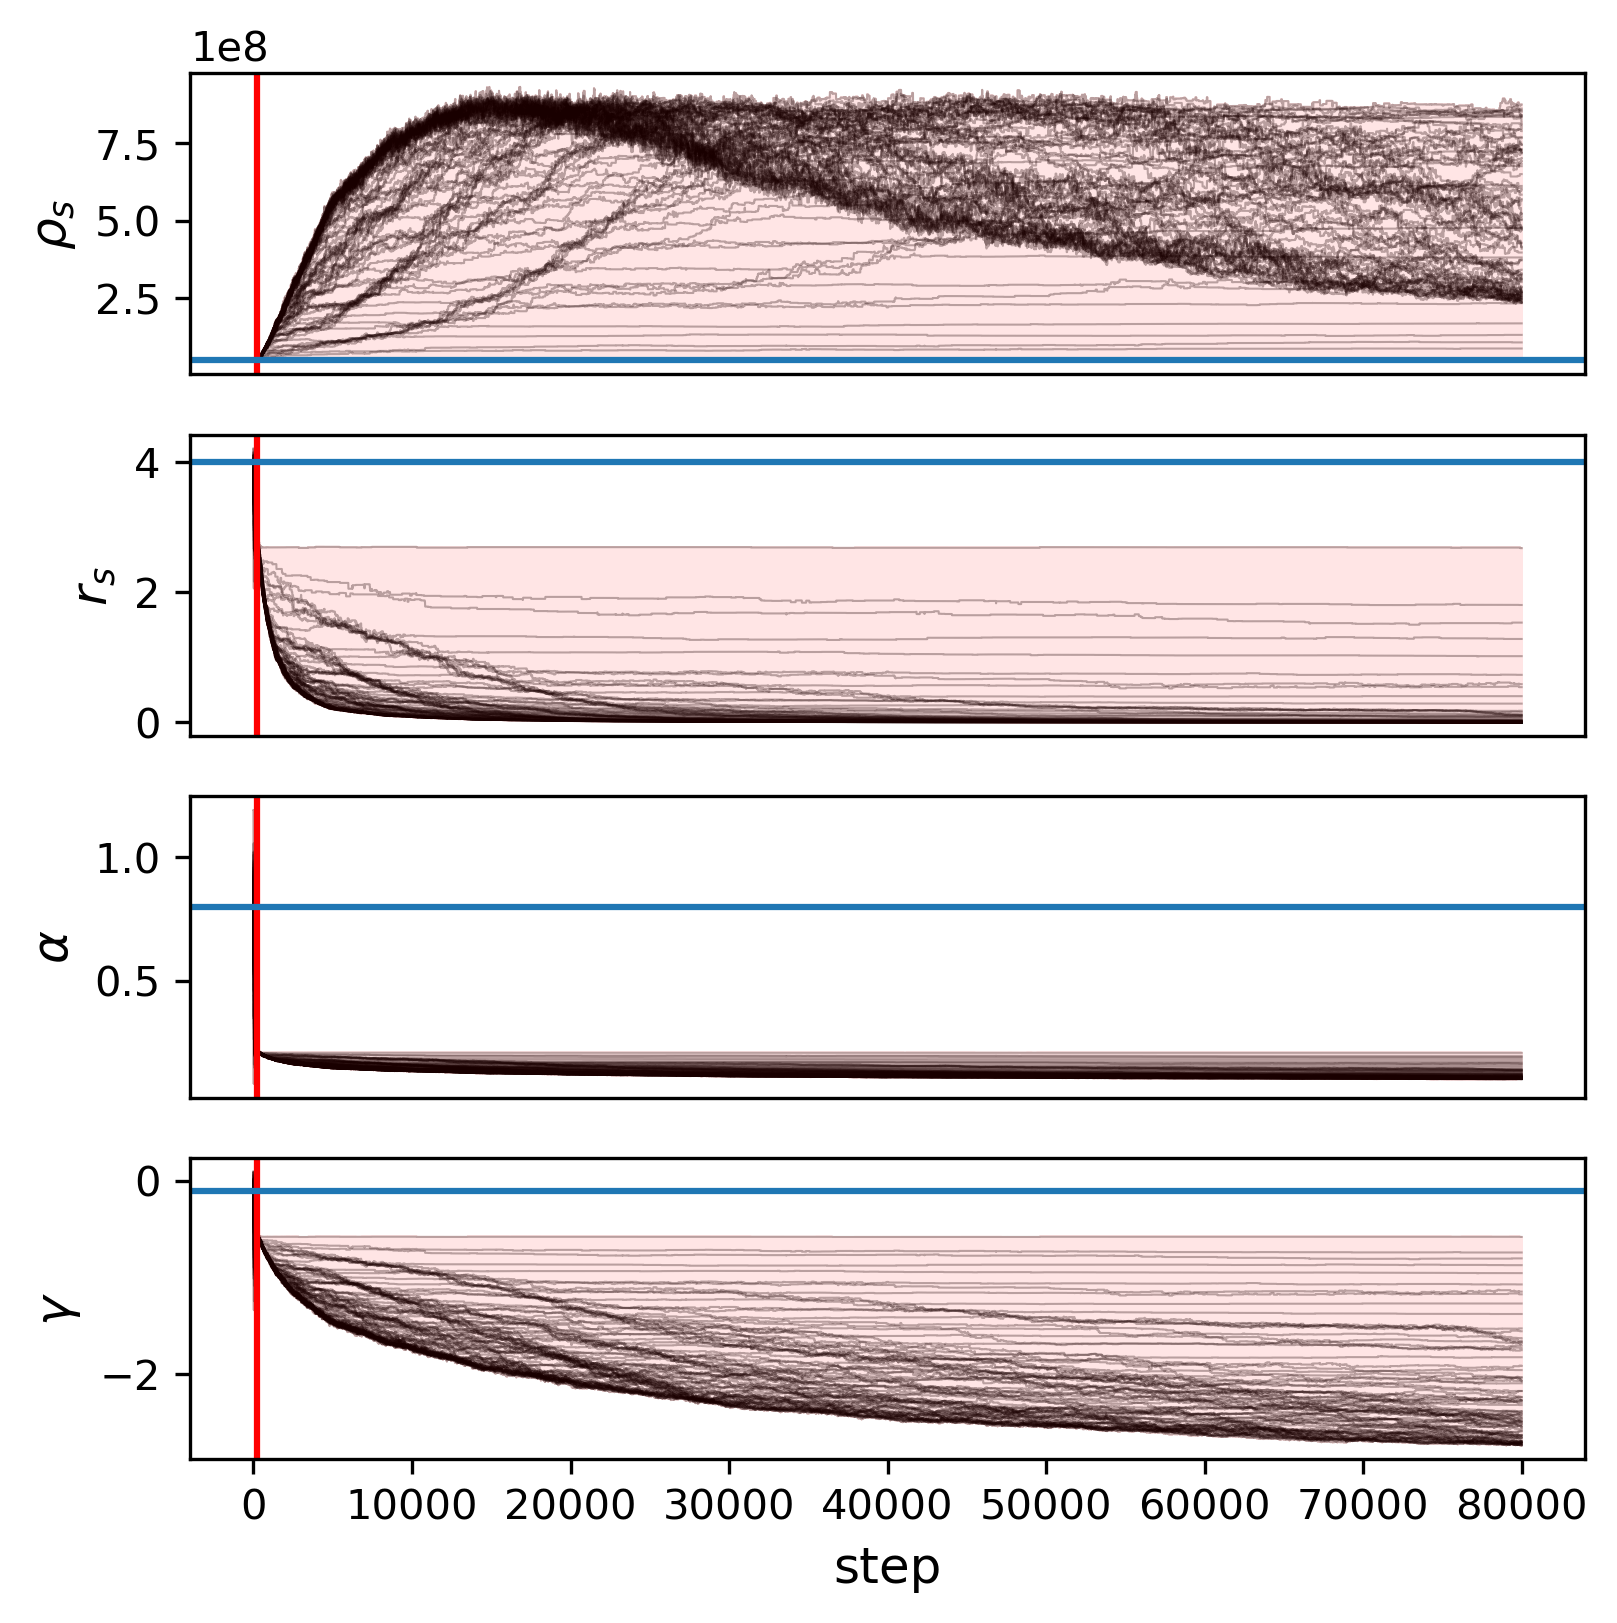

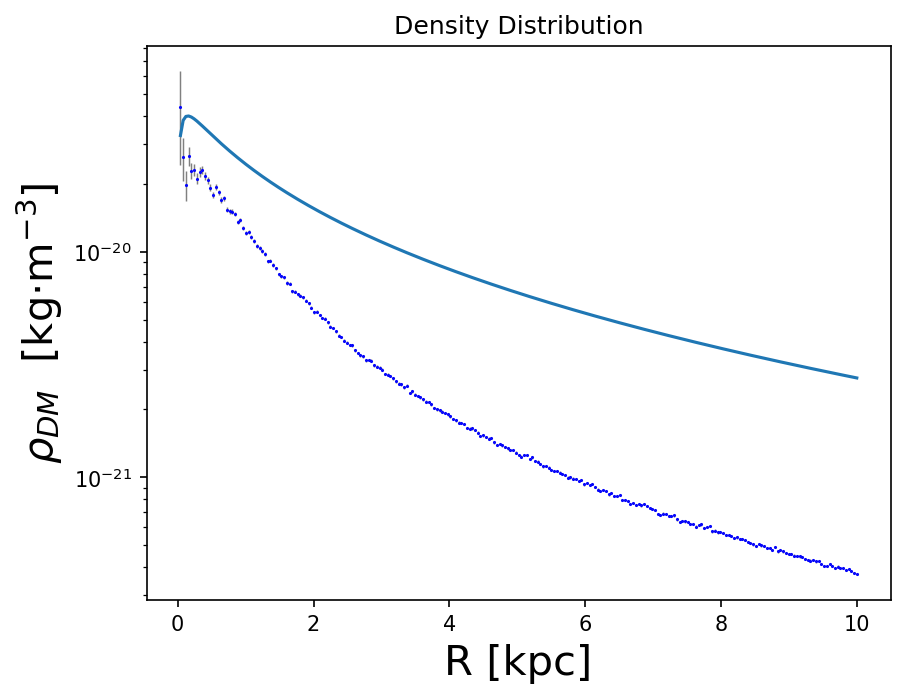

In [234]:
run_mcmc("gEinasto", rho_gEinasto, lnprior_gEinasto, lnprob_gEinasto, [r'$\rho_s$', r'$r_s$', r'$\alpha$', r'$\gamma$'], 
         initial_guess = [5e7,4,0.8,-0.1], nwalkers=80, nsteps=80000, burnout=int(0.4*nsteps))  

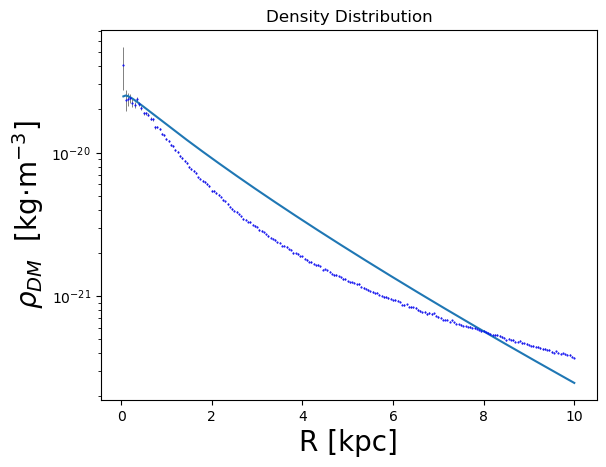

In [142]:
plt.figure(dpi=100)
plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
plt.plot(R_outer, rho_gEinasto(R_outer.value, [5e7,4,0.8,-0.1]))
# plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))   #[1e7,7,2,0.7]

# $\rho_s$=10737+-6840
# $r_s$=7.019+-0.23
# $\alpha$=0.267+-0.00
# $\gamma$=-0.13+-0.01

plt.title("Density Distribution")
plt.xlabel("R [kpc]", size=20)
plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
plt.yscale('log')
plt.show()

In [30]:
nwalkers

20

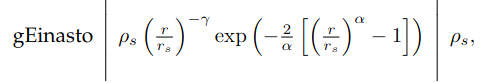

In [227]:
def rho_gEinasto(R, rho_s, r_s, alpha, gamma):
    R_kpc   = R  * u.kpc
    rho_s_msol_kpc3 = rho_s * u.solMass / u.kpc**3
    r_s_kpc = r_s * u.kpc
    
    rho_s_kg_m3 = (rho_s_msol_kpc3).to(u.kg/u.m**3)

    return (rho_s_kg_m3 * (R_kpc/r_s_kpc)**(-gamma) * np.exp((-2/alpha)*((R_kpc/r_s_kpc)**alpha - 1))).value  

# rho_gEinasto(R_outer.value, 1,1,1,1)

In [287]:
# gEinasto



# https://colab.research.google.com/drive/15EsEFbbLiU2NFaNrfiCTlF_i65ShDlmS?usp=sharingw#scrollTo=6zMz_scXL-2_
import emcee
from multiprocessing import Pool,cpu_count

# 1. prior
def lnprior(parameters):
    rho_s, r_s, alpha, gamma = parameters
    if rho_s < 0 or r_s < 0 or r_s > 200 or alpha < 0 or alpha > 5 or gamma < -5 or gamma > 5:
        return -np.inf
    return 0

# 2. likelihood
cov_mat = np.zeros([len(R_outer),len(R_outer)])

for i in range(len(R_outer)):
    cov_mat[i,i] = rho_error[i].value**2
inv_cov = np.linalg.inv(cov_mat)

def lnlike(parameters, x, observation, theory_function):
    rho_s, r_s, alpha, gamma = parameters
    theory = theory_function(x, rho_s, r_s, alpha, gamma)
    
    difference = theory - observation
    
    lnlike = -0.5*float(difference @ inv_cov @ difference)
    return lnlike

# # 3. numerator of Bayes' formula
# def mcmc_emcee(theory_parameters):
#     # don't change this part
#     prior_value = prior(theory_parameters)
#     if np.isinf(prior_value) == False:
#         theory = theory_function(theory_parameters)
#         difference = theory - observation
#         lgprob = -0.5*float(difference @ inv_cov @ difference) + prior_value
#     else:
#         lgprob = -np.inf
#     return lgprob

def lnprob(parameters, x, observation, theory_function):
    # priors
    lgprior = lnprior(parameters)
    if not np.isfinite(lgprior): return -np.inf
    return lgprior + lnlike(parameters, x, observation, theory_function)


# 4. Sampling & MCMC
initial_guess = [1e7,120,1,0.25]
parameter_names = [r'$\rho_s$ [M$_\circ\cdot$kpc$^{-3}$]', r'$r_s$ [kpc]', r'$\alpha$', r'$\gamma$']
# my initial guess of the parameter space

nwalkers = 10*len(initial_guess) # number of mcmc walkers, need to be bigger than 2*parameter dimensions
nsteps = 5000 # iteration numbers, you can adjust this to find a precision-speed balance, emcee don't automatically converge...
ndim = len(initial_guess) # number of parameters
starting_pts = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)] # initial points for each walkers
with Pool() as pool: # parallelization, remove this if you only want 1 cpu
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,pool=pool, args=(R_outer.value, rho.value, rho_gEinasto)) # define your sampler, remove pool=pool if you only want 1 cpu
    sampler.run_mcmc(starting_pts,nsteps,progress=True) 
    # run your mcmc, you can monitor that via a progress bar if you have some package (that I forgot) installed
    # otherwise you need to set progress=False

burnout = int(0.4*nsteps) # burn out points for MCMC for each walkers, 0.1 is just a tradition
analysis_chain = sampler.flatchain[nwalkers*burnout:]
np.save('FIRE/plots/sample_0.npy',sampler.flatchain) # here saves your sampled posterior chain files

100%|██████████| 5000/5000 [03:00<00:00, 27.63it/s]


In [262]:
# parameter_names = [r'$\rho_s$ [M$_\circ\cdot$kpc$^{-3}$]', r'$r_s$ [kpc]', r'$\alpha$', r'$\gamma$']

In [325]:
from astropy.cosmology import WMAP7             # WMAP 7-year cosmology
rho_crit_z0_cgs = WMAP7.critical_density(0)  # critical density at z = 0.5  
rho_crit_z0_si = rho_crit_z05_cgs.to(u.kg / u.m**3)
rho_crit_z0_si.to(u.solMass/u.kpc**3) * 1e4

<Quantity 1375515.9304907 solMass / kpc3>

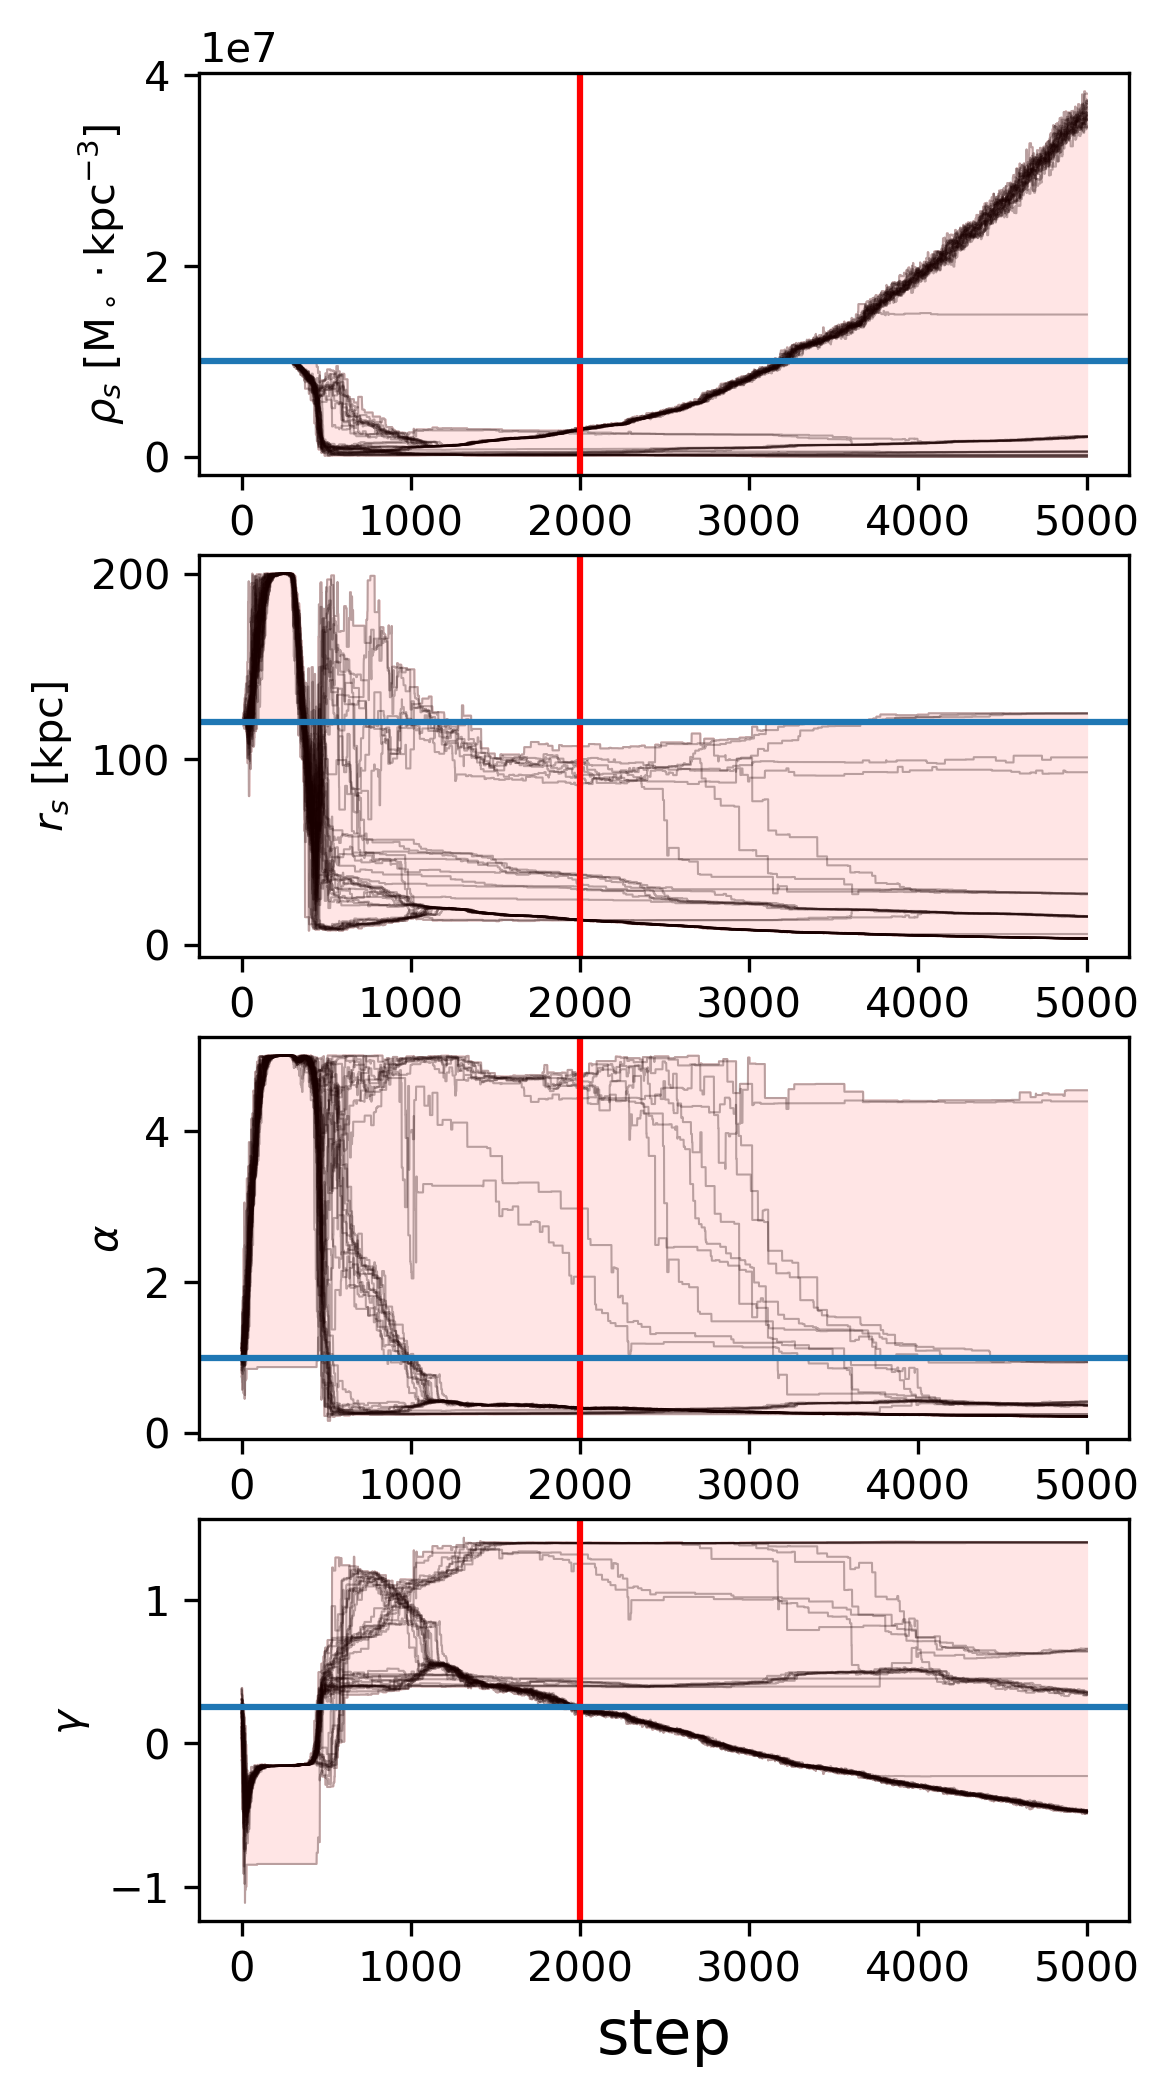

In [288]:
fig,ax = plt.subplots(len(initial_guess),1, dpi=300, figsize=(4,8))
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3, linewidth=0.5) for i in range(len(initial_guess))]
res = [ax[i].plot(np.arange(0,len(sampler.flatchain)/nwalkers,1/nwalkers), sampler.flatchain[0:][:,i], 
                  '-', color='red', alpha=0.1, linewidth=0.5) for i in range(len(initial_guess))]
res = ax[len(initial_guess)-1].set_xlabel("step",size=15)
res = [ax[i].set_ylabel(parameter_names[i], size=10) for i in range(len(initial_guess))]
res = [ax[i].axvline(nwalkers*burnout/nwalkers, color="red") for i in range(len(initial_guess))]
res = [ax[i].axhline(initial_guess[i]) for i in range(len(initial_guess))]
# res = [ax[i].axhline(ptrue[i]) for i in range(4)]

In [ ]:
-----------------------------------------------------------------------

In [183]:
R_array = np.arange(0,1,0.1)
scipy.integrate.cumtrapz(rho_burkert(R_array, vh, r0), x=R_array)

array([3.50511204e-22, 6.96499757e-22, 1.03796595e-21, 1.37491050e-21,
       1.70733475e-21, 2.03524081e-21, 2.35863177e-21, 2.67751183e-21,
       2.99188641e-21])

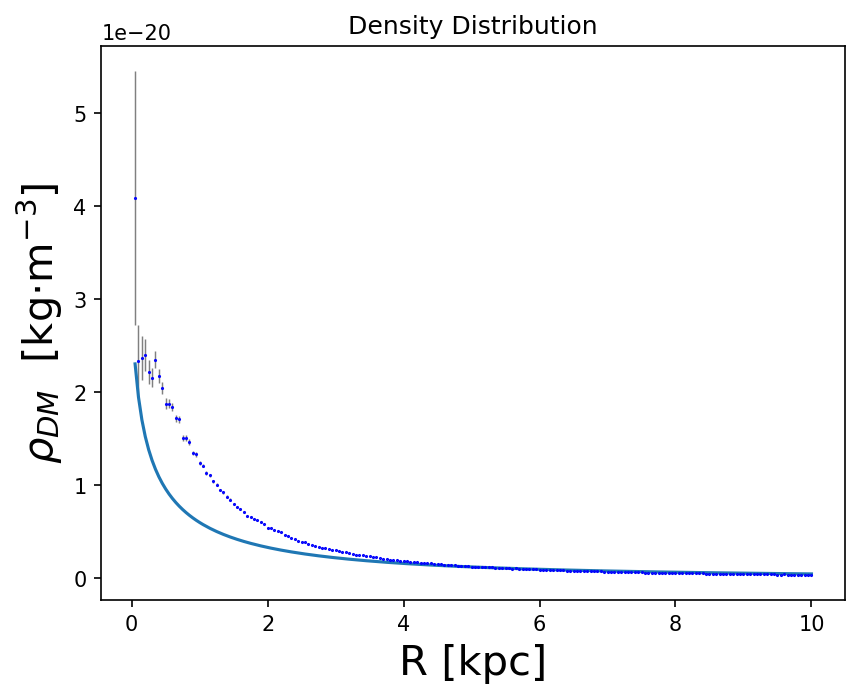

In [331]:
plt.figure(dpi=150)
plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
plt.plot(R_outer, rho_gEinasto(R_outer.value, 7e6,10,0.2,-0.5))
# plt.plot(R_outer, rho_burkert(R_outer.value, res[0][0], res[0][1]))
plt.title("Density Distribution")
plt.xlabel("R [kpc]", size=20)
plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.ylim([10**(-21),10**(-19)])
# plt.xlim([0,5])
# plt.yscale('log')
plt.show()

In [272]:
rho_s = 20000
rho_s_msol_kpc3 = rho_s * u.solMass / u.kpc**3
r_s_kpc = r_s * u.kpc
    
rho_s_kg_m3 = (rho_s_msol_kpc3).to(u.kg/u.m**3)

rho_s_kg_m3

<Quantity 1.35358106e-24 kg / m3>

In [143]:
np.cumsum(rho)

<Quantity [4.09267272e-20, 6.43134285e-20, 8.80078495e-20, 1.11973951e-19,
           1.34189187e-19, 1.55776912e-19, 1.79301723e-19, 2.01097022e-19,
           2.21528952e-19, 2.40322693e-19, 2.59103101e-19, 2.77510392e-19,
           2.94711059e-19, 3.11811663e-19, 3.26873622e-19, 3.41941267e-19,
           3.56596520e-19, 3.70075471e-19, 3.83403335e-19, 3.95833996e-19,
           4.07961636e-19, 4.19285910e-19, 4.30347593e-19, 4.40781671e-19,
           4.50833451e-19, 4.60322187e-19, 4.69550826e-19, 4.78333007e-19,
           4.86791533e-19, 4.94789130e-19, 5.02494154e-19, 5.09920935e-19,
           5.17098646e-19, 5.23816448e-19, 5.30415355e-19, 5.36770430e-19,
           5.43010752e-19, 5.49052054e-19, 5.54934958e-19, 5.60351831e-19,
           5.65780821e-19, 5.71009423e-19, 5.76054459e-19, 5.81001585e-19,
           5.85681418e-19, 5.90252261e-19, 5.94641248e-19, 5.98852091e-19,
           6.02895597e-19, 6.06847288e-19, 6.10704655e-19, 6.14421111e-19,
           6.18012737e-19

In [145]:
a = np.ones(10)
print(a)
print(np.cumsum(a))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [135]:
distance_bins

<Quantity [ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
            0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
            0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
            1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
            1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
            2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
            2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
            3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
            3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
            4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
            4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
            4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
            5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
            5.85,  5.9 ,  5.95,  6.  ,

In [88]:
N

array([  198.,  1298.,  3135.,  5373.,  7644.,  9753., 11737., 13441.,
       14971., 16218., 17433., 18801., 19869., 20677., 21007., 21701.,
       22367., 23239., 23659., 24107., 24755., 25113., 25417., 25935.,
       26072., 26573., 26888., 27189., 27421., 27790., 28239., 28704.,
       28554., 28932., 29046., 29521., 29976., 29728., 30288., 29872.,
       30480., 30901., 30528., 31097., 30826., 31114., 31991., 31618.,
       31800., 31988., 31722., 32288., 32377., 32530., 32529., 32562.,
       32657., 32637., 33194., 32970., 32796., 33198., 33173., 33298.,
       33547., 33123., 33254., 33197., 33403., 33604., 33257., 33391.,
       33384., 33598., 33795., 33110., 33370., 33065., 33420., 33142.,
       32666., 33409., 32950., 33185., 32564., 32874., 32800., 32442.,
       33085., 32642., 32694., 32403., 32300., 32490., 32441., 32193.,
       32371., 32493., 32328., 32095., 32363., 32076., 31925., 31978.,
       32035., 31964., 31721., 31577., 31840., 31603., 31816., 31953.,
      

In [77]:
histogram_results

(array([  198.,  1298.,  3135.,  5373.,  7644.,  9753., 11737., 13441.,
        14971., 16218., 17433., 18801., 19869., 20677., 21007., 21701.,
        22367., 23239., 23659., 24107., 24755., 25113., 25417., 25935.,
        26072., 26573., 26888., 27189., 27421., 27790., 28239., 28704.,
        28554., 28932., 29046., 29521., 29976., 29728., 30288., 29872.,
        30480., 30901., 30528., 31097., 30826., 31114., 31991., 31618.,
        31800., 31988., 31722., 32288., 32377., 32530., 32529., 32562.,
        32657., 32637., 33194., 32970., 32796., 33198., 33173., 33298.,
        33547., 33123., 33254., 33197., 33403., 33604., 33257., 33391.,
        33384., 33598., 33795., 33110., 33370., 33065., 33420., 33142.,
        32666., 33409., 32950., 33185., 32564., 32874., 32800., 32442.,
        33085., 32642., 32694., 32403., 32300., 32490., 32441., 32193.,
        32371., 32493., 32328., 32095., 32363., 32076., 31925., 31978.,
        32035., 31964., 31721., 31577., 31840., 31603., 31816., 

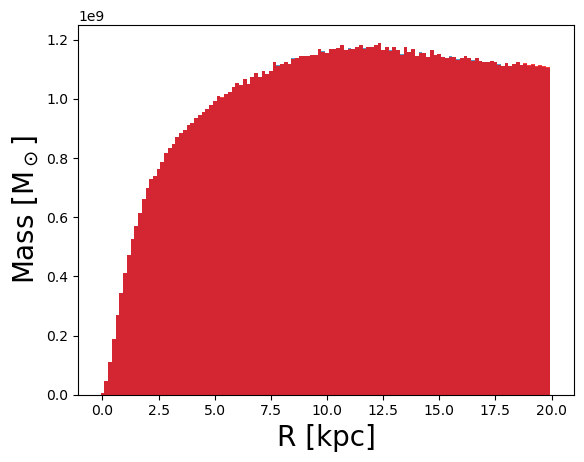

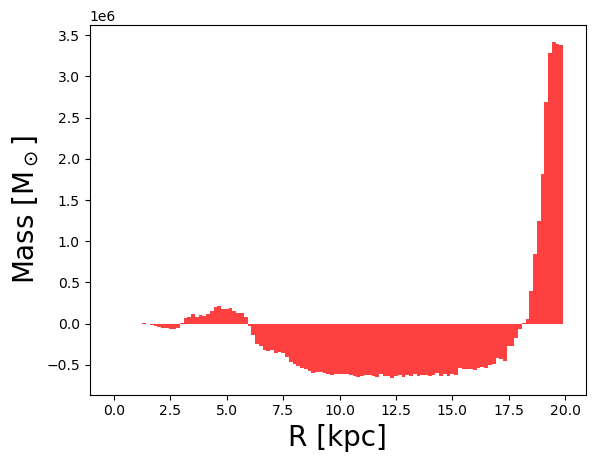

In [63]:
# plt.figure(dpi=100)
# histogram_results = plt.hist(dm, bins=distance_bins.value, 
#                                  weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0.75)
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("Mass [M$_\odot$]", size=20)
# plt.show()

plt.figure(dpi=100)

histogram_results = plt.hist(dm, bins=distance_bins.value, 
                                 weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0)
x_1 = histogram_results[1][0:num_bins]
y_1 = histogram_results[0]
plt.bar(x_1, y_1, width=kpc_per_bin.value, alpha = 0.75)


histogram_results = plt.hist(dm, bins=distance_bins.value, 
                                 color="burlywood", alpha = 0)
x_2 = histogram_results[1][0:num_bins]
y_2 = histogram_results[0] * part['dark']['mass'][within_mw][0]
plt.bar(x_2, y_2, width=kpc_per_bin.value, alpha = 0.75, color="red")


plt.xlabel("R [kpc]", size=20)
plt.ylabel("Mass [M$_\odot$]", size=20)

plt.show()

plt.figure(dpi=100)
plt.bar(x_1, y_2-y_1, width=kpc_per_bin.value, alpha = 0.75, color="red")

plt.xlabel("R [kpc]", size=20)
plt.ylabel("Mass [M$_\odot$]", size=20)

plt.show()


In [3]:
# # Prepare m12i DM data CDF

# # filter by distance to Galaxy
# max_distance_kpc = 10 * u.kpc
# within_mw = part['dark'].prop('host.distance.total') < max_distance_kpc.value

# # array of distances of each particle to the host Galaxy centre
# dm = part['dark'].prop('host.distance.total')[within_mw]

# num_bins = 200

# # create bins array
# distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

# # normalize bins
# kpc_per_bin = max_distance_kpc / num_bins

# # calculate spherical areas at each binned distance
# avg_bin_distances = distance_bins[0:len(distance_bins)-1] + kpc_per_bin/2
# avg_bin_areas = 4 * np.pi * avg_bin_distances**2

# bin_volumes = 4/3*np.pi * (distance_bins[1:len(distance_bins)]**3 - distance_bins[0:len(distance_bins) - 1]**3)

# # bin weighing by particle mass
# plt.figure(dpi=100)
# histogram_results = plt.hist(dm, bins=distance_bins.value, 
#                                  weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0.75)
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("Mass [M$_\odot$]", size=20)
# # plt.savefig("plots/m12i dm mass.png", bbox_inches='tight')
# # plt.savefig("plots/m12i dm mass.svg", bbox_inches='tight')
# plt.show()

# binned_dm_density = histogram_results[0] * u.Msun / bin_volumes
# binned_dm_density_si = binned_dm_density.to(u.kg/u.m**3)

# plt.figure(dpi=100)
# plt.bar(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, width=kpc_per_bin ,color="burlywood", alpha = 0.75)
# plt.yscale('log')
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# # plt.savefig("plots/m12i dm density.png", bbox_inches='tight')
# # plt.savefig("plots/m12i dm density.svg", bbox_inches='tight')
# plt.show()

# # plt.hist(avg_bin_distances.value, bins=distance_bins.value, weights = binned_dm_density_si.value)
# # plt.show()


In [4]:
# # filter by distance to Galaxy
# max_distance_kpc = 10 * u.kpc
# within_mw = part['dark'].prop('host.distance.total') < max_distance_kpc.value

# # array of distances of each particle to the host Galaxy centre
# dm = part['dark'].prop('host.distance.total')[within_mw]

# num_bins = 200

# # create bins array
# distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

# # All DM particles have the same mass:
# mass_dm = (part['dark']['mass'][within_mw][0] * u.Msun).to(u.kg)

# plt.figure(dpi=150, figsize=(4,4))
# res = plt.hist(dm, bins=distance_bins.value, color="burlywood", alpha = 0.75)
# N, R = res[0], res[1] * u.kpc
# R_inner, R_outer = R[0:-1], R[1:]
# plt.title("Particle Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("N", size = 20)
# plt.show()

# N_error = np.sqrt(N)

# m       = N * mass_dm
# m_error = m * N_error / N

# plt.figure(dpi=150)
# plt.errorbar(R_outer, m, yerr=m_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.title("Mass Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("m [kg]", size = 20)
# plt.show()

# V_outer = 4/3 * np.pi * (R_outer).to(u.m)**3
# V_inner = 4/3 * np.pi * (R_inner).to(u.m)**3

# rho       = m / (V_outer-V_inner)
# rho_error = rho * m_error / m

# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# # plt.bar(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, width=kpc_per_bin ,color="burlywood", alpha = 0.75)
# plt.title("Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.show()

# rho_c = np.cumsum(rho)
# rho_c_error = rho_c / np.sqrt(np.cumsum(N))

# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho_c, yerr=rho_c_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# # plt.bar(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, width=kpc_per_bin ,color="burlywood", alpha = 0.75)
# plt.title("Cumulative Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho^c_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.show()

In [39]:
# import scipy
# ########### Burkert Profile #########################################
# dm_model_name = "Burkert Profile"
# vh = 414# * u.km / u.s
# r0 = 7.8# * u.kpc
# # rho0 = (vh**2 / (4*np.pi * r0**2 * cst.G)).to(u.kg/u.m**3)

# def rho_burkert(R, vh, r0):
#     R_kpc   = R  * u.kpc

#     vh_km_s = vh * u.km / u.s
#     r0_kpc  = r0 * u.kpc

#     # print(R_kpc, vh_km_s, r0_kpc)
    
#     rho0_kg_m3 = (vh_km_s**2 / (4*np.pi * r0_kpc**2 * cst.G)).to(u.kg/u.m**3)

#     # print(rho0_kg_m3)
    
#     return (rho0_kg_m3 * r0_kpc**3 / ( (R_kpc+r0_kpc)*((R_kpc)**2 + r0_kpc**2) )).value # kg/m^3
# #####################################################################

# def rho_c_burkert(R, vh, r0):
#     rho_c = np.zeros(len(R))
#     for i in range(len(R)):
#         rho_c[i] = scipy.integrate.quad(rho_burkert, 0, R[i], args=(vh,r0))[0]
#         # rho_c[i] = np.sum(scipy.integrate.cumtrapz(rho_burkert(np.linspace(0,R[i],2000), vh, r0), x=np.linspace(0,R[i],2000)))
#     print("|", end="")
#     return rho_c

# def rho_c_burkert_2(R, vh, r0):
#     rho_c = np.zeros(len(R))
#     for i in range(len(R)):
#         # rho_c[i] = scipy.integrate.quad(rho_burkert, 0, R[i], args=(vh,r0))[0]
#         rho_c[i] = np.sum(scipy.integrate.cumtrapz(rho_burkert(np.linspace(0,R[i],2000), vh, r0), x=np.linspace(0,R[i],2000)))
#     print("|", end="")
#     rho_c = np.append(np.zeros(1),scipy.integrate.cumtrapz(rho_burkert(R, vh, r0), x=R))
#     return rho_c

# # def rho_c_burkert_cumtrapz(R, vh, r0):
# #     R_array = np.arange(0,R,0.1)
# #     return scipy.integrate.cumtrapz(rho_burkert(R_array, vh, r0), x=R_array)

# # print(rho_c_burkert_quad([1,2],vh,r0))
# # print(rho_c_burkert_cumtrapz(1,vh,r0))



# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho_c, yerr=rho_c_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_c_burkert(R_outer.value, vh, r0), color="blue")
# plt.plot(R_outer, rho_c_burkert_2(R_outer.value, vh, r0), color="red")
# plt.title("Cumulative Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho^c_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# plt.show()

In [40]:
# # res = scipy.optimize.curve_fit(rho_c_burkert_quad, R_outer.value, rho_c.value, sigma=rho_c_error.value, p0=(vh,r0))
# res = scipy.optimize.curve_fit(rho_burkert, R_outer.value, rho_c.value, sigma=rho_error.value, p0=(vh,r0), bounds=(-1000,np.inf))
# res

In [41]:
# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_burkert(R_outer.value, res[0][0], res[0][1]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# plt.show()

In [296]:
# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho_c, yerr=rho_c_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, res[0][0], res[0][1]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Cumulative Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho^c_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# plt.show()

In [295]:
# theory_function = rho_c_burkert_quad
# theory_function(R_outer.value, vh,r0)

In [43]:
# # https://colab.research.google.com/drive/15EsEFbbLiU2NFaNrfiCTlF_i65ShDlmS?usp=sharingw#scrollTo=6zMz_scXL-2_
# import emcee
# from multiprocessing import Pool,cpu_count


# # 1. prior
# def lnprior(parameters):
#     vh, r0 = parameters
#     if vh <= 0 or r0 <= 0 or vh*1/(3*10**5)>=1:
#         return -np.inf
#     return 0

# # 2. likelihood
# cov_mat = np.zeros([len(R_outer),len(R_outer)])

# for i in range(len(R_outer)):
#     cov_mat[i,i] = rho_error[i].value**2
# inv_cov = np.linalg.inv(cov_mat)

# def lnlike(parameters, x, observation, theory_function):
#     vh, r0 = parameters
#     theory = theory_function(x, vh, r0)
    
#     difference = theory - observation
    
#     lnlike = -0.5*float(difference @ inv_cov @ difference)
#     return lnlike

# # 3. numerator of Bayes' formula
# def lnprob(parameters, x, observation, theory_function):
#     # priors
#     lgprior = lnprior(parameters)
#     if not np.isfinite(lgprior): return -np.inf
#     return lgprior + lnlike(parameters, x, observation, theory_function)


# # 4. Sampling & MCMC
# initial_guess = [vh, r0]
# parameter_names = ["$v_h$ [km$\cdot$s$^{-1}$]", "$r_0$ [kpc]"]
# # my initial guess of the parameter space

# nwalkers = 10*len(initial_guess) # number of mcmc walkers, need to be bigger than 2*parameter dimensions
# nsteps = 500 # iteration numbers, you can adjust this to find a precision-speed balance, emcee don't automatically converge...
# ndim = len(initial_guess) # number of parameters
# starting_pts = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)] # initial points for each walkers
# with Pool() as pool: # parallelization, remove this if you only want 1 cpu
#     sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,pool=pool, args=(R_outer.value, rho.value, rho_burkert)) # define your sampler, remove pool=pool if you only want 1 cpu
#     sampler.run_mcmc(starting_pts,nsteps,progress=True) 
#     # run your mcmc, you can monitor that via a progress bar if you have some package (that I forgot) installed
#     # otherwise you need to set progress=False

# burnout = int(0.4*nsteps) # burn out points for MCMC for each walkers, 0.1 is just a tradition
# analysis_chain = sampler.flatchain[nwalkers*burnout:]
# np.save('FIRE/plots/sample_0.npy',sampler.flatchain) # here saves your sampled posterior chain files


In [42]:
# fig,ax = plt.subplots(len(initial_guess),1, dpi=300)
# res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3, linewidth=0.5) for i in range(len(initial_guess))]
# res = [ax[i].plot(np.arange(0,len(sampler.flatchain)/nwalkers,1/nwalkers), sampler.flatchain[0:][:,i], 
#                   '-', color='red', alpha=0.1, linewidth=0.5) for i in range(len(initial_guess))]
# res = ax[len(initial_guess)-1].set_xlabel("step",size=15)
# res = [ax[i].set_ylabel(parameter_names[i], size=15) for i in range(len(initial_guess))]
# res = [ax[i].axvline(nwalkers*burnout/nwalkers, color="red") for i in range(len(initial_guess))]
# res = [ax[i].axhline(initial_guess[i]) for i in range(len(initial_guess))]
# # res = [ax[i].axhline(ptrue[i]) for i in range(4)]

In [44]:
# posterior_means = np.average(np.array(analysis_chain),axis=0) # use posterior mean instead of max posterior, which is what mcmc bad at to find
# posterior_std = np.std(np.array(analysis_chain),axis=0)
# toprint = 'The constraints are:\n'
# for i in range(ndim):
#     toprint = toprint+parameter_names[i]+'='+str(posterior_means[i])[:5]+'+-'+str(posterior_std[i])[:4]+"\n"
# print(toprint)
# posterior_std

In [45]:
# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho_c, yerr=rho_c_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_c_burkert_2(R_outer.value, posterior_means[0], posterior_means[1]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Cumulative Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho^c_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# plt.show()

# plt.figure(dpi=150)
# plt.errorbar(R_outer, rho, yerr=rho_error, marker=".", markersize=1, linestyle = 'none',color='blue', ecolor="gray", elinewidth=0.7)
# plt.plot(R_outer, rho_burkert(R_outer.value, posterior_means[0], posterior_means[1]))
# # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
# plt.title("Density Distribution")
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
# plt.yscale('log')
# plt.show()